In [33]:
import cv2
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import xml.etree.ElementTree as ET
from torch.utils.data import Dataset, DataLoader
import os
from sklearn.model_selection import train_test_split
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm


In [34]:
os.chdir(r"C:\Users\Lucas\Desktop\vacantion classes\Yolo project")
from classes.CNN_pytorch_copy import YoloDataset, YoloLoss, YOLOv1, CNN_model, YOLO_visual #import my class CNN

In [35]:
os.chdir(r"C:\Users\Lucas\Desktop\vacantion classes\Yolo project\data\Pascal_VOC\train")

path = r"C:\Users\Lucas\Desktop\vacantion classes\Yolo project\data\Pascal_VOC\train"

xml_list = []
for filename in os.listdir(path):
    if not filename.endswith('.xml'): continue
    fullname = os.path.join(path, filename)
    xml_list.append(fullname)

my_CNN = CNN_model()
my_CNN.get_annotation(xml_list)
my_CNN.encode_pictures()

os.chdir(r"C:\Users\Lucas\Desktop\vacantion classes\Yolo project")
my_CNN.df.to_json(r"data\annot_df.json",orient="records")
torch.save(my_CNN.encoded_picture_annot, r"data\encoded_picture.pt")

In [36]:
os.chdir(r"C:\Users\Lucas\Desktop\vacantion classes\Yolo project")
df_encoded = torch.load(r"data\encoded_picture.pt",weights_only=False)
df_encoded

,file_name,encoded_grid
1,C:\Users\Lucas\Desktop\vacantion classes\Yolo ...,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
2,C:\Users\Lucas\Desktop\vacantion classes\Yolo ...,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
3,C:\Users\Lucas\Desktop\vacantion classes\Yolo ...,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
4,C:\Users\Lucas\Desktop\vacantion classes\Yolo ...,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
5,C:\Users\Lucas\Desktop\vacantion classes\Yolo ...,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
...,...,...
13295,C:\Users\Lucas\Desktop\vacantion classes\Yolo ...,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
13296,C:\Users\Lucas\Desktop\vacantion classes\Yolo ...,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
13297,C:\Users\Lucas\Desktop\vacantion classes\Yolo ...,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
13298,C:\Users\Lucas\Desktop\vacantion classes\Yolo ...,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."


In [37]:
X_train, X_test, y_train, y_test = train_test_split(df_encoded['file_name'],df_encoded['encoded_grid'],test_size=0.4)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [38]:
X_train = X_train[:5]
y_train = y_train[:5]

In [39]:
train_dataset = YoloDataset(X_train, y_train)
test_dataset = YoloDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [40]:
def show_yolo_label(img_tensor, label_tensor, img_size=448, conf_threshold=0.5):
    # Convert tensor to numpy and back to OpenCV format (HWC)
    img = img_tensor.permute(1, 2, 0).numpy()
    img = (img * 255).astype('uint8')
    img = img[..., ::-1].copy()  # RGB -> BGR for OpenCV
    
    # If label is YOLO-style grid (SxSxBx5)
    if label_tensor.ndim == 3:
        S = label_tensor.shape[0]
        for i in range(S):
            for j in range(S):
                cell = label_tensor[i, j]
                if cell[0] > conf_threshold:  # confidence score
                    x, y, w, h = cell[1:5]
                    # Convert to absolute coords
                    x_center = (j + x) / S * img_size
                    y_center = (i + y) / S * img_size
                    w_pixel = w * img_size
                    h_pixel = h * img_size
                    x1 = int(x_center - w_pixel / 2)
                    y1 = int(y_center - h_pixel / 2)
                    x2 = int(x_center + w_pixel / 2)
                    y2 = int(y_center + h_pixel / 2)
                    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    else:
        # Assume label is [class, x, y, w, h] or [x, y, w, h]
        boxes = label_tensor.view(-1, 5 if label_tensor.shape[-1] == 5 else 4)
        for box in boxes:
            if box.numel() == 5:
                _, x, y, w, h = box
            else:
                x, y, w, h = box
            x1 = int((x - w/2) * img_size)
            y1 = int((y - h/2) * img_size)
            x2 = int((x + w/2) * img_size)
            y2 = int((y + h/2) * img_size)
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

    # Show image
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [41]:
def show_yolo_label(img_tensor, label_tensor, img_size=448, conf_threshold=0.5, S=7):
    # Convert tensor to numpy and back to OpenCV format (HWC)
    img = img_tensor.permute(1, 2, 0).numpy()
    img = (img * 255).astype('uint8')
    img = img[..., ::-1].copy()  # RGB -> BGR for OpenCV

    # Draw YOLO grid
    step = img_size // S
    for i in range(1, S):
        # horizontal line
        cv2.line(img, (0, i*step), (img_size, i*step), color=(255, 255, 255), thickness=1)
        # vertical line
        cv2.line(img, (i*step, 0), (i*step, img_size), color=(255, 255, 255), thickness=1)

    # Draw bounding boxes
    if label_tensor.ndim == 3:
        for i in range(S):
            for j in range(S):
                cell = label_tensor[i, j]
                if cell[0] > conf_threshold:  # confidence score
                    x, y, w, h = cell[1:5]
                    # Convert to absolute coords
                    x_center = (j + x) / S * img_size
                    y_center = (i + y) / S * img_size
                    w_pixel = w * img_size
                    h_pixel = h * img_size
                    x1 = int(x_center - w_pixel / 2)
                    y1 = int(y_center - h_pixel / 2)
                    x2 = int(x_center + w_pixel / 2)
                    y2 = int(y_center + h_pixel / 2)
                    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    else:
        boxes = label_tensor.view(-1, 5 if label_tensor.shape[-1] == 5 else 4)
        for box in boxes:
            if box.numel() == 5:
                _, x, y, w, h = box
            else:
                x, y, w, h = box
            x1 = int((x - w/2) * img_size)
            y1 = int((y - h/2) * img_size)
            x2 = int((x + w/2) * img_size)
            y2 = int((y + h/2) * img_size)
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

    # Show image
    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


c:\Users\Lucas\Desktop\vacantion classes\Yolo project\classes\CNN_pytorch_copy.py:319: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(self.Y_tensor[idx], dtype=torch.float32)


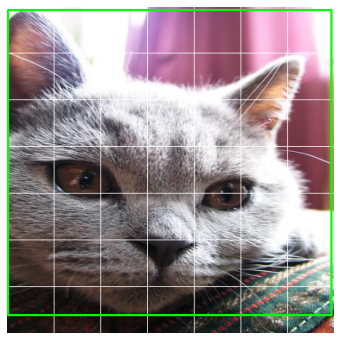

In [42]:
img, label = train_dataset[0]
show_yolo_label(img, label)

In [11]:
label[4]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.]])

Epoch 1/100:   0%|          | 0/1 [00:00<?, ?it/s]

Starting training on cuda for 100 epochs...



c:\Users\Lucas\Desktop\vacantion classes\Yolo project\classes\CNN_pytorch.py:546: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(self.Y_tensor[idx], dtype=torch.float32)


first 10 outputs image 0: tensor([-0.0108,  0.0048,  0.0132,  0.0128,  0.0082,  0.0103, -0.0027,  0.0136,
         0.0048,  0.0153], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0112,  0.0110,  0.0117,  0.0069,  0.0123,  0.0099, -0.0016,  0.0132,
         0.0056,  0.0144], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0., 0.], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([-0.0042,  0.0025], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.8790, 0.4458], device='cuda:0')
pred_wh tensor([0., 0.], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.3100, 0.5843], device='cuda:0')
conf_loss_obj tensor(0.2500, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0501, 0.0501, 0.0496, 0.0502, 0.0504, 0.0506, 0.0504, 0.0494, 0.0502,
        0.0506, 0.0497, 0.0502, 0.0494, 0.0503, 0.0496, 0.0496, 0.0508, 0.0499,
        0.0496, 0.0493], device='cuda:0', grad_fn=<SoftmaxBackward0>)
true_classes tensor([0

Epoch 2/100:   0%|          | 0/1 [00:00<?, ?it/s]                                   

Epoch [1/100] | Avg Loss: 56.5728 | LR: 0.000010
first 10 outputs image 0: tensor([-0.0112,  0.0073,  0.0128,  0.0083,  0.0128,  0.0115, -0.0013,  0.0119,
         0.0043,  0.0141], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0117,  0.0066,  0.0131,  0.0103,  0.0102,  0.0079, -0.0028,  0.0099,
         0.0062,  0.0168], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0., 0.], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([-0.0045,  0.0091], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.4685, 0.9610], device='cuda:0')
pred_wh tensor([0., 0.], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.5345, 0.8060], device='cuda:0')
conf_loss_obj tensor(0.2523, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0493, 0.0508, 0.0492, 0.0504, 0.0497, 0.0502, 0.0509, 0.0501, 0.0497,
        0.0508, 0.0494, 0.0507, 0.0502, 0.0496, 0.0507, 0.0501, 0.0496, 0.0498,
        0.0494, 0.0493], device='cuda:0', g

Epoch 3/100:   0%|          | 0/1 [00:00<?, ?it/s]                                   

Epoch [2/100] | Avg Loss: 56.6022 | LR: 0.000076
first 10 outputs image 0: tensor([-0.0130,  0.0077,  0.0139,  0.0106,  0.0121,  0.0120, -0.0021,  0.0100,
         0.0088,  0.0148], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0114,  0.0049,  0.0130,  0.0104,  0.0141,  0.0100, -0.0005,  0.0125,
         0.0053,  0.0138], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0., 0.], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.0028, 0.0063], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.4685, 0.9610], device='cuda:0')
pred_wh tensor([0., 0.], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.5345, 0.8060], device='cuda:0')
conf_loss_obj tensor(0.2520, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0493, 0.0509, 0.0493, 0.0504, 0.0497, 0.0503, 0.0507, 0.0502, 0.0496,
        0.0508, 0.0493, 0.0508, 0.0502, 0.0495, 0.0507, 0.0500, 0.0496, 0.0497,
        0.0495, 0.0493], device='cuda:0', gra

Epoch 4/100:   0%|          | 0/1 [00:00<?, ?it/s]                                   

Epoch [3/100] | Avg Loss: 56.6045 | LR: 0.000142
first 10 outputs image 0: tensor([-0.0102,  0.0061,  0.0118,  0.0121,  0.0126,  0.0102, -0.0008,  0.0126,
         0.0057,  0.0132], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0118,  0.0077,  0.0155,  0.0098,  0.0136,  0.0075,  0.0010,  0.0109,
         0.0048,  0.0172], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0., 0.], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([-0.0032,  0.0015], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.8790, 0.4458], device='cuda:0')
pred_wh tensor([0.0000, 0.0006], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.3100, 0.5843], device='cuda:0')
conf_loss_obj tensor(0.2497, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0502, 0.0500, 0.0499, 0.0503, 0.0503, 0.0505, 0.0503, 0.0493, 0.0501,
        0.0506, 0.0496, 0.0500, 0.0494, 0.0504, 0.0496, 0.0496, 0.0508, 0.0498,
        0.0497, 0.0495], device='cu

Epoch 5/100:   0%|          | 0/1 [00:00<?, ?it/s]                                   

Epoch [4/100] | Avg Loss: 56.4364 | LR: 0.000208
first 10 outputs image 0: tensor([-0.0104,  0.0073,  0.0100,  0.0098,  0.0079,  0.0079,  0.0013,  0.0124,
         0.0075,  0.0172], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0110,  0.0059,  0.0132,  0.0114,  0.0135,  0.0115, -0.0018,  0.0109,
         0.0025,  0.0167], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0., 0.], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.0043, 0.0143], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.5210, 0.6189], device='cuda:0')
pred_wh tensor([0.0000, 0.0163], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.9100, 0.9660], device='cuda:0')
conf_loss_obj tensor(0.2538, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0501, 0.0503, 0.0499, 0.0495, 0.0497, 0.0497, 0.0498, 0.0500, 0.0496,
        0.0501, 0.0511, 0.0496, 0.0505, 0.0506, 0.0502, 0.0499, 0.0494, 0.0498,
        0.0503, 0.0500], device='cuda

Epoch 6/100:   0%|          | 0/1 [00:00<?, ?it/s]                                   

Epoch [5/100] | Avg Loss: 55.8197 | LR: 0.000274
first 10 outputs image 0: tensor([-0.0123,  0.0062,  0.0129,  0.0100,  0.0124,  0.0113, -0.0016,  0.0130,
         0.0039,  0.0170], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0127,  0.0070,  0.0143,  0.0149,  0.0116,  0.0127, -0.0021,  0.0114,
         0.0066,  0.0164], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0., 0.], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.0069, 0.0131], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.5070, 0.9853], device='cuda:0')
pred_wh tensor([0.0000, 0.0175], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.9980, 0.8613], device='cuda:0')
conf_loss_obj tensor(0.2533, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0502, 0.0501, 0.0500, 0.0496, 0.0499, 0.0497, 0.0497, 0.0501, 0.0497,
        0.0502, 0.0508, 0.0496, 0.0504, 0.0506, 0.0502, 0.0499, 0.0495, 0.0497,
        0.0503, 0.0499], device='cuda

Epoch 7/100:   0%|          | 0/1 [00:00<?, ?it/s]                                   

Epoch [6/100] | Avg Loss: 55.4292 | LR: 0.000340
first 10 outputs image 0: tensor([-0.0111,  0.0051,  0.0152,  0.0105,  0.0132,  0.0079, -0.0018,  0.0098,
         0.0075,  0.0155], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0100,  0.0046,  0.0140,  0.0075,  0.0115,  0.0112, -0.0037,  0.0093,
         0.0054,  0.0161], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0., 0.], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.0052, 0.0145], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.5210, 0.6189], device='cuda:0')
pred_wh tensor([0.0000, 0.0175], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.9100, 0.9660], device='cuda:0')
conf_loss_obj tensor(0.2538, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0501, 0.0504, 0.0498, 0.0495, 0.0498, 0.0496, 0.0498, 0.0500, 0.0496,
        0.0502, 0.0509, 0.0496, 0.0506, 0.0506, 0.0502, 0.0499, 0.0494, 0.0497,
        0.0504, 0.0501], device='cuda

Epoch 8/100:   0%|          | 0/1 [00:00<?, ?it/s]                                   

Epoch [7/100] | Avg Loss: 54.7943 | LR: 0.000406
first 10 outputs image 0: tensor([-0.0103,  0.0046,  0.0113,  0.0102,  0.0123,  0.0094, -0.0015,  0.0099,
         0.0053,  0.0191], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0111,  0.0049,  0.0123,  0.0134,  0.0126,  0.0101, -0.0028,  0.0097,
         0.0055,  0.0144], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0., 0.], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.0050, 0.0156], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.5210, 0.6189], device='cuda:0')
pred_wh tensor([0.0000, 0.0218], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.9100, 0.9660], device='cuda:0')
conf_loss_obj tensor(0.2532, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0501, 0.0500, 0.0498, 0.0496, 0.0497, 0.0497, 0.0498, 0.0503, 0.0496,
        0.0501, 0.0510, 0.0495, 0.0507, 0.0505, 0.0502, 0.0499, 0.0494, 0.0498,
        0.0504, 0.0499], device='cuda

Epoch 9/100:   0%|          | 0/1 [00:00<?, ?it/s]                                   

Epoch [8/100] | Avg Loss: 54.1782 | LR: 0.000472
first 10 outputs image 0: tensor([-0.0107,  0.0065,  0.0143,  0.0128,  0.0092,  0.0071, -0.0021,  0.0082,
         0.0031,  0.0152], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0099,  0.0051,  0.0130,  0.0098,  0.0111,  0.0110,  0.0005,  0.0104,
         0.0044,  0.0141], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.0012, 0.0000], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([-0.0081,  0.0189], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.3190, 0.6667], device='cuda:0')
pred_wh tensor([0.0149, 0.0146], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.5260, 0.3364], device='cuda:0')
conf_loss_obj tensor(0.2521, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0501, 0.0492, 0.0500, 0.0501, 0.0506, 0.0496, 0.0504, 0.0495, 0.0502,
        0.0504, 0.0507, 0.0492, 0.0504, 0.0496, 0.0504, 0.0499, 0.0501, 0.0499,
        0.0498, 0.0500], de

Epoch 10/100:   0%|          | 0/1 [00:00<?, ?it/s]                                  

Epoch [9/100] | Avg Loss: 53.6460 | LR: 0.000538
first 10 outputs image 0: tensor([-0.0125,  0.0078,  0.0103,  0.0098,  0.0114,  0.0065,  0.0019,  0.0109,
         0.0038,  0.0172], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0108,  0.0087,  0.0144,  0.0120,  0.0096,  0.0113, -0.0041,  0.0117,
         0.0061,  0.0163], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0., 0.], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.0011, 0.0028], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.8790, 0.4458], device='cuda:0')
pred_wh tensor([0.0000, 0.0245], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.3100, 0.5843], device='cuda:0')
conf_loss_obj tensor(0.2491, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0501, 0.0502, 0.0497, 0.0503, 0.0503, 0.0504, 0.0506, 0.0493, 0.0502,
        0.0504, 0.0497, 0.0502, 0.0495, 0.0501, 0.0498, 0.0495, 0.0508, 0.0498,
        0.0497, 0.0496], device='cuda

Epoch 11/100:   0%|          | 0/1 [00:00<?, ?it/s]                                   

Epoch [10/100] | Avg Loss: 52.6099 | LR: 0.000604
first 10 outputs image 0: tensor([-1.1463e-02,  4.8112e-03,  1.3560e-02,  1.1383e-02,  1.0629e-02,
         9.2964e-03,  2.7088e-05,  1.1380e-02,  2.6968e-03,  1.6856e-02],
       device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0112,  0.0080,  0.0122,  0.0099,  0.0143,  0.0103, -0.0013,  0.0085,
         0.0061,  0.0153], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0., 0.], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.0100, 0.0243], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.5210, 0.6189], device='cuda:0')
pred_wh tensor([0.0000, 0.0433], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.9100, 0.9660], device='cuda:0')
conf_loss_obj tensor(0.2538, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0500, 0.0502, 0.0497, 0.0495, 0.0499, 0.0497, 0.0499, 0.0501, 0.0495,
        0.0502, 0.0509, 0.0496, 0.0505, 0.0505, 0.0503, 0.0499, 0.049

Epoch 12/100:   0%|          | 0/1 [00:00<?, ?it/s]                                   

Epoch [11/100] | Avg Loss: 51.8440 | LR: 0.000670
first 10 outputs image 0: tensor([-0.0117,  0.0081,  0.0138,  0.0139,  0.0101,  0.0100, -0.0015,  0.0093,
         0.0100,  0.0171], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0109,  0.0097,  0.0146,  0.0109,  0.0089,  0.0088, -0.0011,  0.0097,
         0.0014,  0.0215], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.0043, 0.0000], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([-0.0059,  0.0203], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.3190, 0.6667], device='cuda:0')
pred_wh tensor([0.0296, 0.0259], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.5260, 0.3364], device='cuda:0')
conf_loss_obj tensor(0.2498, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0499, 0.0494, 0.0500, 0.0501, 0.0506, 0.0496, 0.0503, 0.0495, 0.0503,
        0.0502, 0.0507, 0.0492, 0.0505, 0.0496, 0.0502, 0.0499, 0.0502, 0.0499,
        0.0499, 0.0500], d

Epoch 13/100:   0%|          | 0/1 [00:00<?, ?it/s]                                   

Epoch [12/100] | Avg Loss: 50.9502 | LR: 0.000736
first 10 outputs image 0: tensor([-0.0140,  0.0072,  0.0156,  0.0140,  0.0116,  0.0094, -0.0028,  0.0120,
         0.0048,  0.0170], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0131,  0.0078,  0.0110,  0.0126,  0.0141,  0.0093,  0.0002,  0.0120,
         0.0018,  0.0138], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0., 0.], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.0164, 0.0284], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.5070, 0.9853], device='cuda:0')
pred_wh tensor([0.0000, 0.0646], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.9980, 0.8613], device='cuda:0')
conf_loss_obj tensor(0.2537, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0501, 0.0503, 0.0500, 0.0496, 0.0498, 0.0497, 0.0496, 0.0500, 0.0496,
        0.0502, 0.0511, 0.0493, 0.0504, 0.0507, 0.0503, 0.0499, 0.0493, 0.0497,
        0.0501, 0.0502], device='cud

Epoch 14/100:   0%|          | 0/1 [00:00<?, ?it/s]                                   

Epoch [13/100] | Avg Loss: 49.9649 | LR: 0.000802
first 10 outputs image 0: tensor([-0.0099,  0.0087,  0.0142,  0.0124,  0.0134,  0.0096, -0.0003,  0.0131,
         0.0057,  0.0202], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0138,  0.0110,  0.0137,  0.0138,  0.0133,  0.0078, -0.0005,  0.0137,
         0.0034,  0.0170], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0., 0.], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.0018, 0.0220], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.4685, 0.9610], device='cuda:0')
pred_wh tensor([0., 0.], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.5345, 0.8060], device='cuda:0')
conf_loss_obj tensor(0.2526, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0494, 0.0508, 0.0493, 0.0504, 0.0496, 0.0504, 0.0505, 0.0500, 0.0496,
        0.0508, 0.0496, 0.0508, 0.0503, 0.0494, 0.0505, 0.0500, 0.0497, 0.0500,
        0.0495, 0.0493], device='cuda:0', gr

Epoch 15/100:   0%|          | 0/1 [00:00<?, ?it/s]                                   

Epoch [14/100] | Avg Loss: 49.1297 | LR: 0.000868
first 10 outputs image 0: tensor([-0.0121,  0.0061,  0.0115,  0.0149,  0.0132,  0.0101, -0.0039,  0.0087,
         0.0045,  0.0175], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0121,  0.0091,  0.0109,  0.0121,  0.0118,  0.0079, -0.0004,  0.0062,
         0.0035,  0.0134], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0., 0.], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.0169, 0.0052], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.8790, 0.4458], device='cuda:0')
pred_wh tensor([0.0000, 0.0667], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.3100, 0.5843], device='cuda:0')
conf_loss_obj tensor(0.2497, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0501, 0.0498, 0.0496, 0.0503, 0.0506, 0.0505, 0.0505, 0.0492, 0.0503,
        0.0504, 0.0498, 0.0504, 0.0494, 0.0503, 0.0498, 0.0498, 0.0507, 0.0499,
        0.0496, 0.0492], device='cud

Epoch 16/100:   0%|          | 0/1 [00:00<?, ?it/s]                                   

Epoch [15/100] | Avg Loss: 48.0046 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0166,  0.0101,  0.0134,  0.0128,  0.0105,  0.0078,  0.0007,  0.0087,
         0.0041,  0.0193], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0121,  0.0087,  0.0130,  0.0083,  0.0149,  0.0119,  0.0011,  0.0107,
         0.0046,  0.0145], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.0183, 0.0000], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([-0.0007,  0.0308], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.3190, 0.6667], device='cuda:0')
pred_wh tensor([0.0614, 0.0528], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.5260, 0.3364], device='cuda:0')
conf_loss_obj tensor(0.2363, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0499, 0.0494, 0.0504, 0.0500, 0.0504, 0.0494, 0.0506, 0.0495, 0.0502,
        0.0503, 0.0508, 0.0491, 0.0506, 0.0496, 0.0501, 0.0497, 0.0500, 0.0499,
        0.0498, 0.0500], d

Epoch 17/100:   0%|          | 0/1 [00:00<?, ?it/s]                                   

Epoch [16/100] | Avg Loss: 47.0569 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0124,  0.0067,  0.0155,  0.0100,  0.0097,  0.0111, -0.0040,  0.0081,
         0.0092,  0.0173], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0057,  0.0102,  0.0112,  0.0129,  0.0101,  0.0103,  0.0021,  0.0119,
         0.0067,  0.0224], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0., 0.], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.0120, 0.0341], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.4685, 0.9610], device='cuda:0')
pred_wh tensor([0., 0.], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.5345, 0.8060], device='cuda:0')
conf_loss_obj tensor(0.2531, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0496, 0.0508, 0.0494, 0.0504, 0.0495, 0.0503, 0.0505, 0.0503, 0.0496,
        0.0508, 0.0495, 0.0508, 0.0503, 0.0495, 0.0506, 0.0502, 0.0497, 0.0498,
        0.0494, 0.0491], device='cuda:0', gr

Epoch 18/100:   0%|          | 0/1 [00:00<?, ?it/s]                                   

Epoch [17/100] | Avg Loss: 46.2774 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0151,  0.0098,  0.0128,  0.0116,  0.0127,  0.0123, -0.0053,  0.0127,
         0.0053,  0.0197], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-1.6262e-02,  1.1657e-02,  1.3270e-02,  1.1311e-02,  1.1989e-02,
         9.7275e-03, -5.0057e-06,  8.6005e-03,  6.7426e-03,  1.5444e-02],
       device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.0006, 0.0000], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.0322, 0.0132], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.8790, 0.4458], device='cuda:0')
pred_wh tensor([0.0011, 0.0909], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.3100, 0.5843], device='cuda:0')
conf_loss_obj tensor(0.2484, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0503, 0.0500, 0.0497, 0.0502, 0.0505, 0.0505, 0.0504, 0.0492, 0.0503,
        0.0505, 0.0495, 0.0504, 0.0495, 0.0503, 0.0498, 0.049

Epoch 19/100:   0%|          | 0/1 [00:00<?, ?it/s]                                   

Epoch [18/100] | Avg Loss: 45.0908 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0120,  0.0108,  0.0108,  0.0115,  0.0089,  0.0127, -0.0003,  0.0049,
         0.0013,  0.0190], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0091,  0.0064,  0.0119,  0.0116,  0.0123,  0.0143,  0.0010,  0.0071,
         0.0016,  0.0178], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0., 0.], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.0458, 0.0738], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.5210, 0.6189], device='cuda:0')
pred_wh tensor([0.0000, 0.1585], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.9100, 0.9660], device='cuda:0')
conf_loss_obj tensor(0.2523, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0500, 0.0500, 0.0502, 0.0499, 0.0497, 0.0498, 0.0495, 0.0500, 0.0495,
        0.0498, 0.0509, 0.0496, 0.0505, 0.0507, 0.0501, 0.0498, 0.0494, 0.0501,
        0.0502, 0.0501], device='cud

Epoch 20/100:   0%|          | 0/1 [00:00<?, ?it/s]                                   

Epoch [19/100] | Avg Loss: 44.3723 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0157,  0.0117,  0.0139,  0.0140,  0.0121,  0.0059,  0.0024,  0.0110,
         0.0106,  0.0159], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0150,  0.0084,  0.0146,  0.0105,  0.0179,  0.0161,  0.0031,  0.0093,
         0.0062,  0.0149], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0., 0.], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.0476, 0.0864], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.5070, 0.9853], device='cuda:0')
pred_wh tensor([0.0000, 0.1785], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.9980, 0.8613], device='cuda:0')
conf_loss_obj tensor(0.2520, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0499, 0.0500, 0.0500, 0.0497, 0.0493, 0.0498, 0.0498, 0.0502, 0.0500,
        0.0502, 0.0511, 0.0494, 0.0507, 0.0506, 0.0504, 0.0497, 0.0494, 0.0499,
        0.0501, 0.0501], device='cud

Epoch 21/100:   0%|          | 0/1 [00:00<?, ?it/s]                                   

Epoch [20/100] | Avg Loss: 43.3569 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0175,  0.0068,  0.0142,  0.0164,  0.0105,  0.0121, -0.0040,  0.0148,
         0.0086,  0.0168], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0132,  0.0106,  0.0106,  0.0086,  0.0045,  0.0128,  0.0002,  0.0084,
         0.0004,  0.0223], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0., 0.], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.0603, 0.0968], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.5210, 0.6189], device='cuda:0')
pred_wh tensor([0.0000, 0.1933], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.9100, 0.9660], device='cuda:0')
conf_loss_obj tensor(0.2531, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0503, 0.0500, 0.0502, 0.0498, 0.0497, 0.0496, 0.0500, 0.0502, 0.0497,
        0.0502, 0.0508, 0.0492, 0.0506, 0.0505, 0.0503, 0.0498, 0.0494, 0.0498,
        0.0501, 0.0500], device='cud

Epoch 22/100:   0%|          | 0/1 [00:00<?, ?it/s]                                   

Epoch [21/100] | Avg Loss: 42.4953 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0161,  0.0093,  0.0160,  0.0133,  0.0130,  0.0116, -0.0048,  0.0112,
         0.0021,  0.0141], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0193,  0.0051,  0.0058,  0.0178,  0.0126,  0.0068,  0.0038,  0.0053,
        -0.0024,  0.0266], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0., 0.], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.0664, 0.1069], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.5210, 0.6189], device='cuda:0')
pred_wh tensor([0.0000, 0.2179], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.9100, 0.9660], device='cuda:0')
conf_loss_obj tensor(0.2530, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0502, 0.0498, 0.0500, 0.0497, 0.0495, 0.0497, 0.0497, 0.0502, 0.0498,
        0.0502, 0.0509, 0.0495, 0.0504, 0.0509, 0.0502, 0.0496, 0.0496, 0.0499,
        0.0500, 0.0500], device='cud

Epoch 23/100:   0%|          | 0/1 [00:00<?, ?it/s]                                   

Epoch [22/100] | Avg Loss: 41.6483 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0182,  0.0142,  0.0143,  0.0094,  0.0060,  0.0162, -0.0026,  0.0078,
         0.0090,  0.0169], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0174,  0.0124,  0.0138,  0.0153,  0.0121,  0.0143, -0.0037,  0.0074,
         0.0007,  0.0249], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0., 0.], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.0276, 0.0819], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.4685, 0.9610], device='cuda:0')
pred_wh tensor([0.0000, 0.0046], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.5345, 0.8060], device='cuda:0')
conf_loss_obj tensor(0.2517, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0491, 0.0507, 0.0494, 0.0505, 0.0495, 0.0503, 0.0501, 0.0502, 0.0501,
        0.0506, 0.0500, 0.0510, 0.0500, 0.0495, 0.0507, 0.0501, 0.0499, 0.0496,
        0.0496, 0.0491], device='cud

Epoch 24/100:   0%|          | 0/1 [00:00<?, ?it/s]                                   

Epoch [23/100] | Avg Loss: 40.2829 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0051,  0.0136,  0.0194,  0.0103,  0.0081,  0.0080, -0.0019,  0.0060,
         0.0012,  0.0122], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0086,  0.0181,  0.0111,  0.0174,  0.0105,  0.0121,  0.0068,  0.0061,
        -0.0020,  0.0225], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0., 0.], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.0304, 0.0891], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.4685, 0.9610], device='cuda:0')
pred_wh tensor([0.0000e+00, 8.3618e-05], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.5345, 0.8060], device='cuda:0')
conf_loss_obj tensor(0.2511, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0495, 0.0506, 0.0493, 0.0505, 0.0499, 0.0498, 0.0506, 0.0504, 0.0500,
        0.0506, 0.0496, 0.0512, 0.0503, 0.0494, 0.0506, 0.0500, 0.0498, 0.0496,
        0.0493, 0.0488], dev

Epoch 25/100:   0%|          | 0/1 [00:00<?, ?it/s]                                   

Epoch [24/100] | Avg Loss: 40.0749 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0112,  0.0135,  0.0057,  0.0127,  0.0163,  0.0064,  0.0026,  0.0102,
         0.0032,  0.0221], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0161,  0.0131,  0.0203,  0.0133,  0.0181,  0.0117, -0.0006,  0.0115,
        -0.0006,  0.0253], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0., 0.], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.0364, 0.0887], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.4685, 0.9610], device='cuda:0')
pred_wh tensor([0.0000, 0.0093], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.5345, 0.8060], device='cuda:0')
conf_loss_obj tensor(0.2524, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0492, 0.0513, 0.0495, 0.0507, 0.0498, 0.0498, 0.0500, 0.0504, 0.0498,
        0.0505, 0.0496, 0.0507, 0.0503, 0.0495, 0.0509, 0.0503, 0.0500, 0.0498,
        0.0490, 0.0488], device='cud

Epoch 26/100:   0%|          | 0/1 [00:00<?, ?it/s]                                   

Epoch [25/100] | Avg Loss: 39.5184 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0167,  0.0141,  0.0156,  0.0201,  0.0057,  0.0055, -0.0102,  0.0142,
         0.0039,  0.0161], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0082,  0.0106,  0.0152,  0.0098,  0.0133,  0.0172,  0.0002,  0.0097,
         0.0018,  0.0186], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.1017, 0.0000], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.0076, 0.0809], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.3190, 0.6667], device='cuda:0')
pred_wh tensor([0.1476, 0.1220], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.5260, 0.3364], device='cuda:0')
conf_loss_obj tensor(0.1625, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0495, 0.0493, 0.0498, 0.0501, 0.0506, 0.0493, 0.0507, 0.0501, 0.0504,
        0.0505, 0.0509, 0.0493, 0.0503, 0.0496, 0.0503, 0.0496, 0.0499, 0.0498,
        0.0497, 0.0503], dev

Epoch 27/100:   0%|          | 0/1 [00:00<?, ?it/s]                                   

Epoch [26/100] | Avg Loss: 38.1453 | LR: 0.000934
first 10 outputs image 0: tensor([-1.6535e-02,  1.1680e-02,  1.0029e-02,  1.1741e-02,  1.0441e-02,
         1.5890e-02, -7.0917e-05,  2.6276e-03,  1.9585e-03,  1.7138e-02],
       device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0099,  0.0187,  0.0112,  0.0142,  0.0203,  0.0098,  0.0011,  0.0034,
        -0.0038,  0.0204], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0., 0.], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.1083, 0.1859], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.5210, 0.6189], device='cuda:0')
pred_wh tensor([0.0000, 0.2909], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.9100, 0.9660], device='cuda:0')
conf_loss_obj tensor(0.2508, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0499, 0.0499, 0.0502, 0.0503, 0.0491, 0.0499, 0.0497, 0.0504, 0.0498,
        0.0498, 0.0511, 0.0492, 0.0509, 0.0510, 0.0500, 0.0495, 0.049

Epoch 28/100:   0%|          | 0/1 [00:00<?, ?it/s]                                   

Epoch [27/100] | Avg Loss: 40.9122 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0108,  0.0076,  0.0175,  0.0097,  0.0102,  0.0155,  0.0028, -0.0008,
         0.0034,  0.0243], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0171,  0.0183,  0.0150,  0.0106,  0.0046,  0.0082, -0.0082,  0.0018,
         0.0066,  0.0238], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.0690, 0.0000], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.1056, 0.0512], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.8790, 0.4458], device='cuda:0')
pred_wh tensor([0.0686, 0.1824], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.3100, 0.5843], device='cuda:0')
conf_loss_obj tensor(0.1864, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0499, 0.0500, 0.0498, 0.0504, 0.0503, 0.0498, 0.0502, 0.0495, 0.0505,
        0.0506, 0.0497, 0.0497, 0.0490, 0.0509, 0.0500, 0.0500, 0.0508, 0.0500,
        0.0498, 0.0491], dev

Epoch 29/100:   0%|          | 0/1 [00:00<?, ?it/s]                                   

Epoch [28/100] | Avg Loss: 39.7075 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0163,  0.0086,  0.0042,  0.0074,  0.0053,  0.0088, -0.0017,  0.0062,
        -0.0063,  0.0283], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0151,  0.0134,  0.0136,  0.0173,  0.0045,  0.0101,  0.0065,  0.0026,
        -0.0028,  0.0157], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0., 0.], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.0584, 0.1248], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.4685, 0.9610], device='cuda:0')
pred_wh tensor([0.0000, 0.0632], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.5345, 0.8060], device='cuda:0')
conf_loss_obj tensor(0.2522, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0496, 0.0511, 0.0490, 0.0507, 0.0497, 0.0502, 0.0498, 0.0504, 0.0500,
        0.0506, 0.0499, 0.0513, 0.0502, 0.0494, 0.0511, 0.0505, 0.0495, 0.0491,
        0.0494, 0.0487], device='cud

Epoch 30/100:   0%|          | 0/1 [00:00<?, ?it/s]                                   

Epoch [29/100] | Avg Loss: 40.9986 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0125,  0.0108,  0.0010,  0.0152,  0.0138,  0.0163,  0.0013,  0.0154,
         0.0022,  0.0227], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0141,  0.0173,  0.0136, -0.0008,  0.0099,  0.0198,  0.0076,  0.0053,
        -0.0054,  0.0245], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.0988, 0.0000], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.1127, 0.0413], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.8790, 0.4458], device='cuda:0')
pred_wh tensor([0.0922, 0.1954], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.3100, 0.5843], device='cuda:0')
conf_loss_obj tensor(0.1614, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0499, 0.0498, 0.0499, 0.0502, 0.0508, 0.0504, 0.0500, 0.0491, 0.0508,
        0.0506, 0.0493, 0.0499, 0.0493, 0.0508, 0.0499, 0.0496, 0.0511, 0.0499,
        0.0496, 0.0490], dev

Epoch 31/100:   0%|          | 0/1 [00:00<?, ?it/s]                                   

Epoch [30/100] | Avg Loss: 37.3420 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0067,  0.0118,  0.0206,  0.0041,  0.0120,  0.0159, -0.0019,  0.0133,
         0.0047,  0.0221], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0127,  0.0020,  0.0104,  0.0076,  0.0185,  0.0169,  0.0061,  0.0061,
         0.0061,  0.0258], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.0000, 0.0005], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([ 0.0073, -0.0028], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.5070, 0.9853], device='cuda:0')
pred_wh tensor([0.0184, 0.0244], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.9980, 0.8613], device='cuda:0')
conf_loss_obj tensor(0.2535, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0498, 0.0495, 0.0497, 0.0498, 0.0494, 0.0497, 0.0496, 0.0506, 0.0498,
        0.0498, 0.0510, 0.0492, 0.0506, 0.0515, 0.0509, 0.0495, 0.0501, 0.0496,
        0.0502, 0.0498], d

Epoch 32/100:   0%|          | 0/1 [00:00<?, ?it/s]                                   

Epoch [31/100] | Avg Loss: 38.5187 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0040,  0.0137,  0.0059,  0.0321,  0.0104,  0.0052,  0.0008,  0.0204,
         0.0024,  0.0253], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0115,  0.0191,  0.0141,  0.0100,  0.0196,  0.0161,  0.0131,  0.0028,
        -0.0057,  0.0260], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.0000, 0.0020], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([ 0.0066, -0.0060], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.5070, 0.9853], device='cuda:0')
pred_wh tensor([0.0389, 0.0433], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.9980, 0.8613], device='cuda:0')
conf_loss_obj tensor(0.2502, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0503, 0.0496, 0.0499, 0.0498, 0.0486, 0.0497, 0.0496, 0.0502, 0.0501,
        0.0500, 0.0513, 0.0492, 0.0503, 0.0509, 0.0500, 0.0499, 0.0498, 0.0499,
        0.0501, 0.0508], d

Epoch 33/100:   0%|          | 0/1 [00:00<?, ?it/s]                                   

Epoch [32/100] | Avg Loss: 36.8788 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0224,  0.0120,  0.0120,  0.0104,  0.0209,  0.0192,  0.0052,  0.0125,
         0.0040,  0.0324], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0162,  0.0132,  0.0054,  0.0144,  0.0188,  0.0147,  0.0011,  0.0251,
        -0.0057,  0.0250], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.0000, 0.0047], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([ 0.0025, -0.0046], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.5070, 0.9853], device='cuda:0')
pred_wh tensor([0.0601, 0.0667], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.9980, 0.8613], device='cuda:0')
conf_loss_obj tensor(0.2482, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0497, 0.0500, 0.0496, 0.0496, 0.0490, 0.0498, 0.0497, 0.0505, 0.0504,
        0.0502, 0.0511, 0.0490, 0.0501, 0.0513, 0.0506, 0.0495, 0.0498, 0.0500,
        0.0507, 0.0496], d

Epoch 34/100:   0%|          | 0/1 [00:00<?, ?it/s]                                   

Epoch [33/100] | Avg Loss: 36.0778 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0207,  0.0194,  0.0103,  0.0069,  0.0051,  0.0294,  0.0088,  0.0088,
        -0.0006,  0.0249], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0097,  0.0148,  0.0035,  0.0115, -0.0006,  0.0157, -0.0037,  0.0136,
        -0.0035,  0.0294], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0., 0.], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.0766, 0.1614], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.4685, 0.9610], device='cuda:0')
pred_wh tensor([0.0000, 0.1163], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.5345, 0.8060], device='cuda:0')
conf_loss_obj tensor(0.2512, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0492, 0.0514, 0.0499, 0.0502, 0.0493, 0.0498, 0.0504, 0.0497, 0.0494,
        0.0508, 0.0499, 0.0510, 0.0505, 0.0497, 0.0517, 0.0497, 0.0501, 0.0491,
        0.0495, 0.0487], device='cud

Epoch 35/100:   0%|          | 0/1 [00:00<?, ?it/s]                                   

Epoch [34/100] | Avg Loss: 35.2451 | LR: 0.000934
first 10 outputs image 0: tensor([-2.9057e-02,  1.1437e-02,  3.6481e-05, -6.7217e-04,  8.0439e-03,
         1.8871e-02, -2.6532e-03,  8.1780e-03, -1.6246e-03,  3.7661e-02],
       device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0222,  0.0273,  0.0066,  0.0147,  0.0157,  0.0243,  0.0123,  0.0148,
         0.0016,  0.0220], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.0087, 0.0104], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.0150, 0.0113], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.5070, 0.9853], device='cuda:0')
pred_wh tensor([0.0945, 0.0948], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.9980, 0.8613], device='cuda:0')
conf_loss_obj tensor(0.2417, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0491, 0.0497, 0.0498, 0.0501, 0.0492, 0.0492, 0.0496, 0.0502, 0.0514,
        0.0499, 0.0513, 0.0493, 0.0509, 0.0514, 0.0496, 0.049

Epoch 36/100:   0%|          | 0/1 [00:00<?, ?it/s]                                   

Epoch [35/100] | Avg Loss: 33.5070 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0137,  0.0183, -0.0027,  0.0049,  0.0177,  0.0199,  0.0267,  0.0043,
         0.0171,  0.0166], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0094,  0.0162,  0.0166,  0.0248,  0.0197,  0.0251,  0.0129,  0.0143,
        -0.0130,  0.0258], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.0086, 0.0148], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.0120, 0.0126], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.5210, 0.6189], device='cuda:0')
pred_wh tensor([0.1120, 0.1165], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.9100, 0.9660], device='cuda:0')
conf_loss_obj tensor(0.2375, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0503, 0.0498, 0.0493, 0.0498, 0.0492, 0.0495, 0.0487, 0.0506, 0.0506,
        0.0498, 0.0511, 0.0491, 0.0505, 0.0505, 0.0507, 0.0494, 0.0505, 0.0502,
        0.0495, 0.0509], dev

Epoch 37/100:   0%|          | 0/1 [00:00<?, ?it/s]                                   

Epoch [36/100] | Avg Loss: 32.6180 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0164,  0.0207,  0.0170, -0.0038,  0.0254,  0.0237, -0.0016,  0.0101,
         0.0084,  0.0355], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0281,  0.0127,  0.0095,  0.0056,  0.0101,  0.0020,  0.0121,  0.0093,
        -0.0060,  0.0317], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.2442, 0.0000], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.0410, 0.1398], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.3190, 0.6667], device='cuda:0')
pred_wh tensor([0.2382, 0.1814], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.5260, 0.3364], device='cuda:0')
conf_loss_obj tensor(0.0691, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0493, 0.0496, 0.0495, 0.0497, 0.0509, 0.0497, 0.0513, 0.0493, 0.0506,
        0.0508, 0.0525, 0.0490, 0.0495, 0.0497, 0.0495, 0.0491, 0.0490, 0.0493,
        0.0501, 0.0514], dev

Epoch 38/100:   0%|          | 0/1 [00:00<?, ?it/s]                                   

Epoch [37/100] | Avg Loss: 31.7386 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0202,  0.0173,  0.0131,  0.0151,  0.0235,  0.0117,  0.0040,  0.0284,
        -0.0051,  0.0159], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0022,  0.0136,  0.0071, -0.0036,  0.0109,  0.0252, -0.0043,  0.0148,
         0.0056,  0.0301], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.2355, 0.0000], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.0573, 0.1469], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.3190, 0.6667], device='cuda:0')
pred_wh tensor([0.2380, 0.1751], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.5260, 0.3364], device='cuda:0')
conf_loss_obj tensor(0.0733, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0502, 0.0501, 0.0494, 0.0502, 0.0500, 0.0500, 0.0513, 0.0495, 0.0505,
        0.0511, 0.0509, 0.0489, 0.0500, 0.0503, 0.0493, 0.0496, 0.0501, 0.0491,
        0.0496, 0.0498], dev

Epoch 39/100:   0%|          | 0/1 [00:00<?, ?it/s]                                   

Epoch [38/100] | Avg Loss: 30.2718 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0131,  0.0194,  0.0109,  0.0154,  0.0056, -0.0069,  0.0039,  0.0159,
        -0.0217,  0.0175], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0110,  0.0086,  0.0059,  0.0129,  0.0256,  0.0246,  0.0062,  0.0058,
        -0.0059,  0.0396], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.0091, 0.0387], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.0099, 0.0523], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.5210, 0.6189], device='cuda:0')
pred_wh tensor([0.1799, 0.1889], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.9100, 0.9660], device='cuda:0')
conf_loss_obj tensor(0.2102, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0502, 0.0509, 0.0490, 0.0499, 0.0493, 0.0491, 0.0492, 0.0501, 0.0501,
        0.0516, 0.0513, 0.0501, 0.0503, 0.0505, 0.0501, 0.0500, 0.0489, 0.0491,
        0.0495, 0.0509], dev

Epoch 40/100:   0%|          | 0/1 [00:00<?, ?it/s]                                   

Epoch [39/100] | Avg Loss: 29.0378 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0361,  0.0178,  0.0034,  0.0106, -0.0058,  0.0176,  0.0035,  0.0082,
        -0.0043,  0.0186], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0122,  0.0195,  0.0142,  0.0172,  0.0178,  0.0185, -0.0028, -0.0013,
         0.0093,  0.0399], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.0139, 0.0433], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.0675, 0.0462], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.5210, 0.6189], device='cuda:0')
pred_wh tensor([0.1887, 0.2018], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.9100, 0.9660], device='cuda:0')
conf_loss_obj tensor(0.2070, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0495, 0.0502, 0.0495, 0.0506, 0.0487, 0.0497, 0.0499, 0.0505, 0.0504,
        0.0498, 0.0507, 0.0501, 0.0500, 0.0505, 0.0505, 0.0495, 0.0494, 0.0499,
        0.0492, 0.0515], dev

Epoch 41/100:   0%|          | 0/1 [00:00<?, ?it/s]                                   

Epoch [40/100] | Avg Loss: 28.2451 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0197,  0.0215,  0.0051, -0.0094, -0.0022,  0.0083, -0.0046,  0.0018,
        -0.0225,  0.0264], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0075,  0.0316, -0.0006,  0.0075, -0.0044,  0.0219,  0.0144,  0.0197,
        -0.0073,  0.0461], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.2174, 0.0000], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.2058, 0.0781], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.8790, 0.4458], device='cuda:0')
pred_wh tensor([0.1679, 0.2868], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.3100, 0.5843], device='cuda:0')
conf_loss_obj tensor(0.0825, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0499, 0.0495, 0.0498, 0.0495, 0.0504, 0.0503, 0.0516, 0.0496, 0.0507,
        0.0511, 0.0490, 0.0495, 0.0495, 0.0505, 0.0489, 0.0494, 0.0508, 0.0505,
        0.0497, 0.0496], dev

Epoch 42/100:   0%|          | 0/1 [00:00<?, ?it/s]                                   

Epoch [41/100] | Avg Loss: 26.7646 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0146,  0.0095,  0.0153,  0.0040,  0.0202,  0.0101,  0.0320, -0.0063,
        -0.0241,  0.0308], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0100,  0.0210,  0.0135,  0.0011,  0.0201,  0.0329,  0.0128,  0.0147,
        -0.0083,  0.0313], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.0069, 0.0841], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.0782, 0.0899], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.5070, 0.9853], device='cuda:0')
pred_wh tensor([0.2712, 0.2666], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.9980, 0.8613], device='cuda:0')
conf_loss_obj tensor(0.1728, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0497, 0.0501, 0.0492, 0.0501, 0.0488, 0.0495, 0.0496, 0.0507, 0.0507,
        0.0495, 0.0508, 0.0492, 0.0505, 0.0505, 0.0500, 0.0498, 0.0506, 0.0501,
        0.0505, 0.0500], dev

Epoch 43/100:   0%|          | 0/1 [00:00<?, ?it/s]                                   

Epoch [42/100] | Avg Loss: 25.6959 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0287,  0.0283,  0.0053,  0.0332,  0.0023,  0.0167, -0.0229,  0.0228,
        -0.0053,  0.0451], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0285,  0.0243,  0.0083,  0.0296,  0.0095,  0.0194,  0.0219, -0.0038,
        -0.0111,  0.0358], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([6.2648e-02, 3.8721e-05], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.1047, 0.2712], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.4685, 0.9610], device='cuda:0')
pred_wh tensor([0.1167, 0.2312], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.5345, 0.8060], device='cuda:0')
conf_loss_obj tensor(0.1942, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0492, 0.0516, 0.0489, 0.0511, 0.0492, 0.0501, 0.0502, 0.0499, 0.0498,
        0.0503, 0.0496, 0.0506, 0.0513, 0.0503, 0.0511, 0.0504, 0.0492, 0.0500,
        0.0488, 0.04

Epoch 44/100:   0%|          | 0/1 [00:00<?, ?it/s]                                   

Epoch [43/100] | Avg Loss: 24.5977 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0137,  0.0465,  0.0017,  0.0404, -0.0048,  0.0244,  0.0243,  0.0014,
        -0.0125,  0.0364], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0348,  0.0169,  0.0184,  0.0038,  0.0149,  0.0128,  0.0259, -0.0032,
        -0.0094,  0.0310], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.1109, 0.0000], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.1222, 0.3085], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.4685, 0.9610], device='cuda:0')
pred_wh tensor([0.1780, 0.2683], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.5345, 0.8060], device='cuda:0')
conf_loss_obj tensor(0.1544, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0489, 0.0506, 0.0490, 0.0509, 0.0486, 0.0498, 0.0493, 0.0499, 0.0506,
        0.0500, 0.0507, 0.0515, 0.0504, 0.0503, 0.0514, 0.0499, 0.0502, 0.0498,
        0.0493, 0.0491], dev

Epoch 45/100:   0%|          | 0/1 [00:00<?, ?it/s]                                   

Epoch [44/100] | Avg Loss: 23.3417 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0263,  0.0111,  0.0069,  0.0235,  0.0303,  0.0241, -0.0111,  0.0044,
        -0.0067,  0.0463], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0282,  0.0276, -0.0028,  0.0054,  0.0115,  0.0304,  0.0334,  0.0170,
        -0.0117,  0.0440], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.0257, 0.1434], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.1135, 0.1967], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.5210, 0.6189], device='cuda:0')
pred_wh tensor([0.3738, 0.3374], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.9100, 0.9660], device='cuda:0')
conf_loss_obj tensor(0.1258, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0491, 0.0503, 0.0496, 0.0506, 0.0477, 0.0494, 0.0500, 0.0517, 0.0494,
        0.0505, 0.0509, 0.0484, 0.0509, 0.0526, 0.0497, 0.0497, 0.0486, 0.0498,
        0.0501, 0.0511], dev

Epoch 46/100:   0%|          | 0/1 [00:00<?, ?it/s]                                   

Epoch [45/100] | Avg Loss: 21.5738 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0326,  0.0094,  0.0053,  0.0181, -0.0076,  0.0190,  0.0034, -0.0052,
        -0.0424,  0.0337], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0366,  0.0318,  0.0157,  0.0146,  0.0217,  0.0049,  0.0096,  0.0139,
        -0.0205,  0.0208], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.0287, 0.1698], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.1279, 0.1970], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.5070, 0.9853], device='cuda:0')
pred_wh tensor([0.3871, 0.3770], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.9980, 0.8613], device='cuda:0')
conf_loss_obj tensor(0.1065, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0486, 0.0512, 0.0497, 0.0502, 0.0480, 0.0488, 0.0496, 0.0514, 0.0514,
        0.0509, 0.0508, 0.0486, 0.0505, 0.0512, 0.0497, 0.0501, 0.0483, 0.0513,
        0.0496, 0.0499], dev

Epoch 47/100:   0%|          | 0/1 [00:00<?, ?it/s]                                   

Epoch [46/100] | Avg Loss: 21.0076 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0232,  0.0088, -0.0106, -0.0010,  0.0087,  0.0420,  0.0188, -0.0228,
        -0.0005,  0.0100], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0295,  0.0379,  0.0103,  0.0082,  0.0129,  0.0089, -0.0204, -0.0231,
        -0.0102,  0.0511], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.3616, 0.0000], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.3296, 0.1222], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.8790, 0.4458], device='cuda:0')
pred_wh tensor([0.2245, 0.3726], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.3100, 0.5843], device='cuda:0')
conf_loss_obj tensor(0.0206, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0506, 0.0482, 0.0493, 0.0499, 0.0514, 0.0511, 0.0488, 0.0497, 0.0492,
        0.0507, 0.0496, 0.0509, 0.0508, 0.0506, 0.0489, 0.0499, 0.0513, 0.0495,
        0.0502, 0.0496], dev

Epoch 48/100:   0%|          | 0/1 [00:00<?, ?it/s]                                   

Epoch [47/100] | Avg Loss: 19.6992 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0328,  0.0592, -0.0080, -0.0123, -0.0044,  0.0479,  0.0005, -0.0110,
         0.0178,  0.0303], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0052,  0.0237, -0.0125, -0.0054,  0.0175,  0.0141,  0.0442,  0.0036,
        -0.0286,  0.0496], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.1815, 0.0000], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.1480, 0.3551], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.4685, 0.9610], device='cuda:0')
pred_wh tensor([0.2349, 0.3330], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.5345, 0.8060], device='cuda:0')
conf_loss_obj tensor(0.1009, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0483, 0.0513, 0.0483, 0.0498, 0.0476, 0.0505, 0.0508, 0.0493, 0.0511,
        0.0502, 0.0489, 0.0516, 0.0513, 0.0507, 0.0516, 0.0497, 0.0499, 0.0493,
        0.0498, 0.0502], dev

Epoch 49/100:   0%|          | 0/1 [00:00<?, ?it/s]                                   

Epoch [48/100] | Avg Loss: 18.7202 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0093,  0.0286, -0.0184, -0.0060, -0.0015,  0.0132,  0.0114,  0.0463,
        -0.0060,  0.0543], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0396,  0.0011,  0.0224, -0.0139,  0.0209,  0.0123,  0.0026,  0.0182,
        -0.0405,  0.0389], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.5099, 0.0000], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.1296, 0.3132], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.3190, 0.6667], device='cuda:0')
pred_wh tensor([0.3551, 0.3114], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.5260, 0.3364], device='cuda:0')
conf_loss_obj tensor(6.1645e-06, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0479, 0.0523, 0.0487, 0.0487, 0.0509, 0.0493, 0.0525, 0.0496, 0.0506,
        0.0493, 0.0536, 0.0478, 0.0492, 0.0521, 0.0493, 0.0494, 0.0491, 0.0503,
        0.0492, 0.0502],

Epoch 50/100:   0%|          | 0/1 [00:00<?, ?it/s]                                   

Epoch [49/100] | Avg Loss: 17.3132 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0044,  0.0338,  0.0044,  0.0267,  0.0292, -0.0004, -0.0065,  0.0118,
        -0.0071,  0.0434], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0377,  0.0529,  0.0177, -0.0166,  0.0045,  0.0374,  0.0578,  0.0143,
         0.0126,  0.0519], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.0215, 0.3347], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.2654, 0.3314], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.5070, 0.9853], device='cuda:0')
pred_wh tensor([0.5340, 0.5389], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.9980, 0.8613], device='cuda:0')
conf_loss_obj tensor(0.0260, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0502, 0.0511, 0.0477, 0.0520, 0.0480, 0.0481, 0.0490, 0.0494, 0.0510,
        0.0496, 0.0512, 0.0518, 0.0504, 0.0503, 0.0509, 0.0509, 0.0486, 0.0498,
        0.0485, 0.0514], dev

Epoch 51/100:   0%|          | 0/1 [00:00<?, ?it/s]                                   

Epoch [50/100] | Avg Loss: 15.9943 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0266,  0.0404, -0.0330,  0.0407,  0.0441,  0.0611,  0.0205,  0.0138,
        -0.0285,  0.0094], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0121,  0.0461, -0.0066, -0.0124, -0.0003, -0.0028, -0.0181, -0.0050,
        -0.0507,  0.0519], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.0314, 0.4159], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.2549, 0.3776], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.5070, 0.9853], device='cuda:0')
pred_wh tensor([0.6109, 0.5853], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.9980, 0.8613], device='cuda:0')
conf_loss_obj tensor(0.0073, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0516, 0.0483, 0.0485, 0.0501, 0.0481, 0.0486, 0.0517, 0.0509, 0.0510,
        0.0485, 0.0531, 0.0502, 0.0496, 0.0512, 0.0491, 0.0507, 0.0499, 0.0495,
        0.0494, 0.0500], dev

Epoch 52/100:   0%|          | 0/1 [00:00<?, ?it/s]                                   

Epoch [51/100] | Avg Loss: 14.5194 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0002,  0.0407,  0.0128,  0.0013, -0.0009,  0.0312,  0.0346,  0.0284,
        -0.0073,  0.0456], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0324,  0.0359, -0.0006,  0.0280,  0.0078,  0.0304,  0.0382,  0.0203,
        -0.0078,  0.0354], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.0523, 0.3818], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.2822, 0.4255], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.5070, 0.9853], device='cuda:0')
pred_wh tensor([0.5893, 0.5570], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.9980, 0.8613], device='cuda:0')
conf_loss_obj tensor(0.0136, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0508, 0.0491, 0.0510, 0.0517, 0.0475, 0.0485, 0.0486, 0.0495, 0.0502,
        0.0500, 0.0520, 0.0505, 0.0503, 0.0504, 0.0511, 0.0492, 0.0494, 0.0492,
        0.0499, 0.0511], dev

Epoch 53/100:   0%|          | 0/1 [00:00<?, ?it/s]                                   

Epoch [52/100] | Avg Loss: 13.3017 | LR: 0.000934
first 10 outputs image 0: tensor([-1.0009e-02,  2.5068e-02, -7.9430e-03, -4.6706e-02,  3.5743e-02,
        -3.7520e-03,  1.4951e-02, -1.8140e-02, -1.6811e-02,  8.9686e-05],
       device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0228,  0.0442,  0.0010, -0.0155,  0.0333,  0.0237,  0.0644,  0.0142,
         0.0298,  0.0628], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.4139, 0.0007], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.2629, 0.5590], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.4685, 0.9610], device='cuda:0')
pred_wh tensor([0.3703, 0.4815], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.5345, 0.8060], device='cuda:0')
conf_loss_obj tensor(0.0095, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0500, 0.0529, 0.0497, 0.0499, 0.0491, 0.0490, 0.0495, 0.0476, 0.0501,
        0.0514, 0.0501, 0.0510, 0.0503, 0.0492, 0.0539, 0.051

Epoch 54/100:   0%|          | 0/1 [00:00<?, ?it/s]                                   

Epoch [53/100] | Avg Loss: 12.0504 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0388,  0.0336,  0.0081,  0.0232,  0.0118,  0.0748,  0.0436, -0.0533,
         0.0105,  0.0873], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0093,  0.0602, -0.0343, -0.0065, -0.0037,  0.0617,  0.0334,  0.0390,
         0.0119,  0.0933], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.0470, 0.6239], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.4057, 0.5997], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.5070, 0.9853], device='cuda:0')
pred_wh tensor([0.7653, 0.7008], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.9980, 0.8613], device='cuda:0')
conf_loss_obj tensor(0.0136, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0506, 0.0476, 0.0501, 0.0521, 0.0459, 0.0488, 0.0501, 0.0516, 0.0497,
        0.0489, 0.0522, 0.0516, 0.0502, 0.0499, 0.0490, 0.0497, 0.0489, 0.0506,
        0.0510, 0.0516], dev

Epoch 55/100:   0%|          | 0/1 [00:00<?, ?it/s]                                   

Epoch [54/100] | Avg Loss: 11.3251 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0378,  0.0640, -0.0621,  0.0262,  0.0302,  0.0350,  0.0131, -0.0519,
        -0.0502, -0.0028], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0517,  0.0309,  0.0076,  0.0111,  0.0250,  0.0481,  0.0175, -0.0045,
        -0.0882,  0.0388], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([5.0416e-01, 1.8384e-04], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.2685, 0.6262], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.4685, 0.9610], device='cuda:0')
pred_wh tensor([0.4237, 0.5127], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.5345, 0.8060], device='cuda:0')
conf_loss_obj tensor(4.1551e-05, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0484, 0.0531, 0.0492, 0.0506, 0.0506, 0.0496, 0.0491, 0.0471, 0.0501,
        0.0515, 0.0499, 0.0533, 0.0504, 0.0503, 0.0528, 0.0495, 0.0492, 0.0483,
        0.0496, 

Epoch 56/100:   0%|          | 0/1 [00:00<?, ?it/s]                                   

Epoch [55/100] | Avg Loss: 10.5244 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0724,  0.0322, -0.0143, -0.0117,  0.0280,  0.0255,  0.0546,  0.0207,
        -0.0133,  0.0353], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0106,  0.0275, -0.0494,  0.0091,  0.0484,  0.1075,  0.0060, -0.0446,
        -0.0567,  0.0319], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.0439, 0.9006], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.4266, 0.7921], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.5210, 0.6189], device='cuda:0')
pred_wh tensor([0.9513, 0.9070], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.9100, 0.9660], device='cuda:0')
conf_loss_obj tensor(0.1538, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0521, 0.0517, 0.0475, 0.0499, 0.0486, 0.0467, 0.0500, 0.0504, 0.0531,
        0.0494, 0.0509, 0.0507, 0.0502, 0.0526, 0.0495, 0.0490, 0.0492, 0.0482,
        0.0505, 0.0499], dev

Epoch 57/100:   0%|          | 0/1 [00:00<?, ?it/s]                                  

Epoch [56/100] | Avg Loss: 9.2954 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0118,  0.0195,  0.0013,  0.0076, -0.0383,  0.0528,  0.0152, -0.0173,
        -0.0601, -0.0144], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([ 0.0267,  0.0018, -0.0138, -0.0137, -0.0067,  0.1225,  0.0527, -0.0383,
        -0.0653,  0.0315], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.7213, 0.0000], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.3421, 0.7617], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.4685, 0.9610], device='cuda:0')
pred_wh tensor([0.4819, 0.6449], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.5345, 0.8060], device='cuda:0')
conf_loss_obj tensor(0.0514, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0491, 0.0521, 0.0494, 0.0506, 0.0504, 0.0481, 0.0497, 0.0488, 0.0497,
        0.0470, 0.0538, 0.0519, 0.0516, 0.0509, 0.0542, 0.0489, 0.0491, 0.0468,
        0.0501, 0.0478], devi

Epoch 58/100:   0%|          | 0/1 [00:00<?, ?it/s]                                  

Epoch [57/100] | Avg Loss: 8.9838 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0061, -0.0178, -0.0480,  0.0583,  0.0642,  0.0680,  0.0105, -0.0282,
        -0.0288, -0.0163], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0823,  0.0550, -0.0074,  0.0063, -0.0087,  0.0256,  0.0132,  0.0352,
        -0.0205, -0.0036], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.0405, 0.8681], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.5243, 0.8529], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.5210, 0.6189], device='cuda:0')
pred_wh tensor([0.9796, 0.8983], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.9100, 0.9660], device='cuda:0')
conf_loss_obj tensor(0.1363, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0492, 0.0487, 0.0508, 0.0538, 0.0460, 0.0488, 0.0473, 0.0493, 0.0506,
        0.0478, 0.0521, 0.0498, 0.0505, 0.0538, 0.0503, 0.0498, 0.0494, 0.0502,
        0.0491, 0.0527], devi

Epoch 59/100:   0%|          | 0/1 [00:00<?, ?it/s]                                  

Epoch [58/100] | Avg Loss: 8.6805 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0651,  0.0287,  0.0542, -0.0165,  0.0367,  0.0470,  0.0343,  0.0947,
        -0.0392,  0.0255], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0312,  0.0524, -0.0553,  0.0160,  0.0271,  0.0845,  0.1483,  0.0025,
        -0.0058,  0.0254], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.7030, 0.0000], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.4798, 0.9335], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.4685, 0.9610], device='cuda:0')
pred_wh tensor([0.6697, 0.6891], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.5345, 0.8060], device='cuda:0')
conf_loss_obj tensor(0.0387, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0486, 0.0531, 0.0463, 0.0501, 0.0474, 0.0507, 0.0501, 0.0503, 0.0536,
        0.0495, 0.0527, 0.0528, 0.0521, 0.0514, 0.0502, 0.0479, 0.0513, 0.0484,
        0.0490, 0.0444], devi

Epoch 60/100:   0%|          | 0/1 [00:00<?, ?it/s]                                  

Epoch [59/100] | Avg Loss: 8.4881 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0017,  0.0209, -0.0548,  0.0112,  0.0168,  0.0580,  0.0387, -0.0594,
        -0.0614,  0.0955], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([ 0.0167,  0.0672,  0.0311, -0.0387,  0.0576,  0.0871,  0.0947, -0.0077,
        -0.0158,  0.0615], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.7532, 0.0017], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.4580, 1.0349], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.4685, 0.9610], device='cuda:0')
pred_wh tensor([0.6929, 0.7815], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.5345, 0.8060], device='cuda:0')
conf_loss_obj tensor(0.0684, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0475, 0.0528, 0.0488, 0.0498, 0.0499, 0.0505, 0.0488, 0.0494, 0.0511,
        0.0472, 0.0526, 0.0552, 0.0496, 0.0477, 0.0547, 0.0516, 0.0464, 0.0468,
        0.0513, 0.0482], devi

Epoch 61/100:   0%|          | 0/1 [00:00<?, ?it/s]                                  

Epoch [60/100] | Avg Loss: 8.6540 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0102,  0.0424,  0.0135, -0.0011, -0.0345,  0.0623,  0.0515, -0.0095,
        -0.0703,  0.0616], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0271,  0.0839, -0.0057,  0.0161, -0.0108,  0.0748,  0.0327,  0.0429,
        -0.0729,  0.0784], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.5519, 0.0000], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([1.0024, 0.4068], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.8790, 0.4458], device='cuda:0')
pred_wh tensor([0.4786, 0.6858], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.3100, 0.5843], device='cuda:0')
conf_loss_obj tensor(0.0024, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0495, 0.0443, 0.0498, 0.0486, 0.0526, 0.0464, 0.0491, 0.0530, 0.0535,
        0.0529, 0.0481, 0.0502, 0.0504, 0.0493, 0.0500, 0.0508, 0.0540, 0.0498,
        0.0481, 0.0495], devi

Epoch 62/100:   0%|          | 0/1 [00:00<?, ?it/s]                                  

Epoch [61/100] | Avg Loss: 9.1134 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0723, -0.0149, -0.0776,  0.0375,  0.0523,  0.0809,  0.0430,  0.0309,
        -0.0416,  0.0277], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0460,  0.0701, -0.0780,  0.0176,  0.0119,  0.0435,  0.0789, -0.0012,
         0.0355,  0.1146], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.6039, 0.0000], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.3322, 0.7623], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.3190, 0.6667], device='cuda:0')
pred_wh tensor([0.6472, 0.4527], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.5260, 0.3364], device='cuda:0')
conf_loss_obj tensor(0.0073, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0445, 0.0549, 0.0519, 0.0472, 0.0545, 0.0488, 0.0545, 0.0484, 0.0511,
        0.0465, 0.0561, 0.0439, 0.0498, 0.0527, 0.0482, 0.0493, 0.0476, 0.0522,
        0.0470, 0.0510], devi

Epoch 63/100:   0%|          | 0/1 [00:00<?, ?it/s]                                  

Epoch [62/100] | Avg Loss: 8.6683 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0502, -0.0071,  0.0719, -0.0009,  0.0412,  0.0903, -0.0095, -0.0259,
        -0.0466,  0.0544], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0750, -0.0163, -0.0299, -0.0095,  0.0247, -0.0023,  0.0526,  0.0015,
        -0.0469,  0.0156], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([6.6291e-01, 8.1074e-05], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.5464, 1.1181], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.4685, 0.9610], device='cuda:0')
pred_wh tensor([0.7381, 0.8805], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.5345, 0.8060], device='cuda:0')
conf_loss_obj tensor(0.0306, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0479, 0.0518, 0.0471, 0.0520, 0.0499, 0.0507, 0.0471, 0.0477, 0.0516,
        0.0496, 0.0515, 0.0508, 0.0505, 0.0542, 0.0541, 0.0480, 0.0522, 0.0473,
        0.0486, 0.047

Epoch 64/100:   0%|          | 0/1 [00:00<?, ?it/s]                                  

Epoch [63/100] | Avg Loss: 9.2414 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0134,  0.0886,  0.0236,  0.0223,  0.0018, -0.0300,  0.0400, -0.0062,
        -0.1093,  0.0636], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0534, -0.0409, -0.0135, -0.0062,  0.0369,  0.0319,  0.0420,  0.0462,
        -0.0593,  0.0933], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.0188, 0.6821], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.7021, 0.9756], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.5210, 0.6189], device='cuda:0')
pred_wh tensor([1.1289, 1.1415], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.9100, 0.9660], device='cuda:0')
conf_loss_obj tensor(0.0318, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0470, 0.0512, 0.0503, 0.0536, 0.0473, 0.0494, 0.0450, 0.0502, 0.0513,
        0.0478, 0.0524, 0.0516, 0.0483, 0.0520, 0.0499, 0.0483, 0.0527, 0.0497,
        0.0513, 0.0507], devi

Epoch 65/100:   0%|          | 0/1 [00:00<?, ?it/s]                                  

Epoch [64/100] | Avg Loss: 9.0625 | LR: 0.000934
first 10 outputs image 0: tensor([-0.1288,  0.0415, -0.0516,  0.0466,  0.0031,  0.0501,  0.0466, -0.0300,
        -0.0583,  0.0280], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0596,  0.0772, -0.0113,  0.0074,  0.0290,  0.0473,  0.0778,  0.0228,
        -0.0407,  0.0735], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.6182, 0.0000], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.3607, 0.7955], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.3190, 0.6667], device='cuda:0')
pred_wh tensor([0.6230, 0.4595], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.5260, 0.3364], device='cuda:0')
conf_loss_obj tensor(0.0088, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0469, 0.0551, 0.0463, 0.0487, 0.0519, 0.0477, 0.0559, 0.0491, 0.0522,
        0.0493, 0.0564, 0.0465, 0.0494, 0.0510, 0.0468, 0.0496, 0.0448, 0.0502,
        0.0480, 0.0544], devi

Epoch 66/100:   0%|          | 0/1 [00:00<?, ?it/s]                                  

Epoch [65/100] | Avg Loss: 9.3865 | LR: 0.000934
first 10 outputs image 0: tensor([-0.1054,  0.0486, -0.0212,  0.0057,  0.0066, -0.0105,  0.0042, -0.0048,
        -0.0106,  0.0911], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.1178,  0.0638,  0.0345,  0.0060,  0.0625,  0.1092,  0.0099,  0.0199,
         0.0041,  0.0536], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.7945, 0.0000], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.5428, 1.1019], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.4685, 0.9610], device='cuda:0')
pred_wh tensor([0.6423, 0.8129], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.5345, 0.8060], device='cuda:0')
conf_loss_obj tensor(0.0914, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0495, 0.0487, 0.0473, 0.0554, 0.0501, 0.0460, 0.0467, 0.0464, 0.0535,
        0.0507, 0.0527, 0.0516, 0.0524, 0.0462, 0.0567, 0.0507, 0.0494, 0.0478,
        0.0497, 0.0487], devi

Epoch 67/100:   0%|          | 0/1 [00:00<?, ?it/s]                                  

Epoch [66/100] | Avg Loss: 9.4128 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0199,  0.0748,  0.0195,  0.0109,  0.0413,  0.1267,  0.0334,  0.0457,
        -0.0252,  0.0209], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0494,  0.0087, -0.0108,  0.0580,  0.0122,  0.0542,  0.0557, -0.0255,
        -0.0395,  0.0431], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.8702, 0.0000], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.9702, 0.4579], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.8790, 0.4458], device='cuda:0')
pred_wh tensor([0.3166, 0.6189], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.3100, 0.5843], device='cuda:0')
conf_loss_obj tensor(0.1310, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0532, 0.0503, 0.0489, 0.0491, 0.0503, 0.0474, 0.0483, 0.0498, 0.0527,
        0.0495, 0.0487, 0.0470, 0.0465, 0.0537, 0.0527, 0.0502, 0.0538, 0.0491,
        0.0504, 0.0484], devi

Epoch 68/100:   0%|          | 0/1 [00:00<?, ?it/s]                                  

Epoch [67/100] | Avg Loss: 8.5802 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0878,  0.0733, -0.0074,  0.0158,  0.0346,  0.0796,  0.0332,  0.0103,
        -0.0283,  0.0295], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.1517,  0.0208, -0.0955, -0.0089,  0.0691, -0.0108,  0.0854, -0.0270,
         0.0176, -0.0478], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.6512, 0.0000], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.9961, 0.5488], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.8790, 0.4458], device='cuda:0')
pred_wh tensor([0.4305, 0.6461], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.3100, 0.5843], device='cuda:0')
conf_loss_obj tensor(0.0253, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0468, 0.0476, 0.0500, 0.0500, 0.0517, 0.0529, 0.0490, 0.0491, 0.0539,
        0.0509, 0.0486, 0.0489, 0.0465, 0.0483, 0.0498, 0.0514, 0.0510, 0.0482,
        0.0523, 0.0533], devi

Epoch 69/100:   0%|          | 0/1 [00:00<?, ?it/s]                                  

Epoch [68/100] | Avg Loss: 8.4790 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0867,  0.0073, -0.0549, -0.0271,  0.0608,  0.0066,  0.0517, -0.0054,
        -0.0276,  0.0579], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0279,  0.0932, -0.0591, -0.0109,  0.0226,  0.0524,  0.0517,  0.0073,
         0.0246,  0.0354], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.8277, 0.0000], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.3452, 0.7002], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.3190, 0.6667], device='cuda:0')
pred_wh tensor([0.5857, 0.3073], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.5260, 0.3364], device='cuda:0')
conf_loss_obj tensor(0.0927, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0468, 0.0540, 0.0466, 0.0505, 0.0508, 0.0516, 0.0522, 0.0481, 0.0506,
        0.0533, 0.0527, 0.0464, 0.0488, 0.0541, 0.0514, 0.0463, 0.0440, 0.0506,
        0.0502, 0.0509], devi

Epoch 70/100:   0%|          | 0/1 [00:00<?, ?it/s]                                  

Epoch [69/100] | Avg Loss: 8.2569 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0976,  0.1086,  0.0534, -0.0543,  0.0637,  0.0131,  0.0635,  0.0581,
        -0.0338,  0.1032], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0522,  0.0348, -0.0413, -0.0078,  0.0725,  0.0932,  0.0526, -0.0368,
        -0.0225,  0.0725], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.0918, 0.7408], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.5059, 0.8235], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.5070, 0.9853], device='cuda:0')
pred_wh tensor([1.1096, 1.0458], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.9980, 0.8613], device='cuda:0')
conf_loss_obj tensor(0.0563, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0467, 0.0514, 0.0479, 0.0516, 0.0507, 0.0481, 0.0467, 0.0491, 0.0499,
        0.0502, 0.0540, 0.0510, 0.0480, 0.0540, 0.0480, 0.0525, 0.0524, 0.0488,
        0.0489, 0.0502], devi

Epoch 71/100:   0%|          | 0/1 [00:00<?, ?it/s]                                  

Epoch [70/100] | Avg Loss: 8.1442 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0601,  0.0453, -0.0478, -0.0326,  0.0320,  0.0108,  0.0020, -0.0167,
        -0.0789,  0.0494], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0886,  0.0430, -0.0058, -0.1106, -0.0192,  0.0957,  0.0685, -0.0270,
        -0.0203, -0.0149], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.7819, 0.0000], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.9224, 0.4978], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.8790, 0.4458], device='cuda:0')
pred_wh tensor([0.3622, 0.6397], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.3100, 0.5843], device='cuda:0')
conf_loss_obj tensor(0.0763, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0509, 0.0492, 0.0491, 0.0508, 0.0494, 0.0500, 0.0461, 0.0512, 0.0527,
        0.0483, 0.0477, 0.0486, 0.0481, 0.0494, 0.0504, 0.0513, 0.0540, 0.0495,
        0.0519, 0.0516], devi

Epoch 72/100:   0%|          | 0/1 [00:00<?, ?it/s]                                  

Epoch [71/100] | Avg Loss: 8.1641 | LR: 0.000934
first 10 outputs image 0: tensor([-0.1085,  0.0243, -0.0422,  0.0236,  0.0272, -0.0003, -0.0074, -0.0178,
         0.0015,  0.0740], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0537,  0.0417,  0.0162,  0.0402,  0.0348,  0.0141,  0.0441,  0.0016,
        -0.1000, -0.0031], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.0896, 0.7817], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.5016, 0.8144], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.5070, 0.9853], device='cuda:0')
pred_wh tensor([1.0908, 1.0081], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.9980, 0.8613], device='cuda:0')
conf_loss_obj tensor(0.0760, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0504, 0.0519, 0.0475, 0.0556, 0.0448, 0.0477, 0.0487, 0.0528, 0.0577,
        0.0493, 0.0543, 0.0482, 0.0476, 0.0516, 0.0475, 0.0520, 0.0475, 0.0463,
        0.0471, 0.0516], devi

Epoch 73/100:   0%|          | 0/1 [00:00<?, ?it/s]                                  

Epoch [72/100] | Avg Loss: 7.9395 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0615,  0.0566, -0.0387,  0.0053,  0.0145,  0.0867,  0.0612, -0.0573,
        -0.0122,  0.0390], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.1130,  0.0066, -0.0145, -0.0669,  0.0291,  0.0249, -0.0221, -0.0162,
        -0.0542,  0.0729], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.8170, 0.0000], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.8659, 0.4569], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.8790, 0.4458], device='cuda:0')
pred_wh tensor([0.2724, 0.5434], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.3100, 0.5843], device='cuda:0')
conf_loss_obj tensor(0.1079, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0489, 0.0486, 0.0473, 0.0519, 0.0524, 0.0506, 0.0489, 0.0493, 0.0507,
        0.0496, 0.0496, 0.0502, 0.0515, 0.0479, 0.0494, 0.0518, 0.0501, 0.0494,
        0.0508, 0.0511], devi

Epoch 74/100:   0%|          | 0/1 [00:00<?, ?it/s]                                  

Epoch [73/100] | Avg Loss: 8.5309 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0446,  0.0351, -0.0580, -0.0886,  0.0734,  0.0685,  0.0226, -0.0105,
        -0.0266,  0.0444], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0290,  0.0438, -0.0675,  0.0288,  0.0174,  0.0421,  0.0499, -0.0334,
        -0.0856,  0.0284], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.8992, 0.0000], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.9435, 0.4885], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.8790, 0.4458], device='cuda:0')
pred_wh tensor([0.3137, 0.6132], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.3100, 0.5843], device='cuda:0')
conf_loss_obj tensor(0.1709, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0497, 0.0475, 0.0491, 0.0493, 0.0509, 0.0533, 0.0497, 0.0474, 0.0532,
        0.0520, 0.0482, 0.0524, 0.0466, 0.0505, 0.0497, 0.0490, 0.0500, 0.0512,
        0.0492, 0.0509], devi

Epoch 75/100:   0%|          | 0/1 [00:00<?, ?it/s]                                  

Epoch [74/100] | Avg Loss: 8.1610 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0845,  0.0312, -0.0066, -0.0104,  0.0509, -0.0255,  0.0795, -0.0285,
        -0.0448,  0.0314], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0471,  0.0827, -0.0650,  0.0445, -0.0210,  0.0739,  0.0245,  0.0033,
        -0.0922,  0.0291], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.0773, 0.8770], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.4400, 0.6766], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.5210, 0.6189], device='cuda:0')
pred_wh tensor([1.0208, 0.9694], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.9100, 0.9660], device='cuda:0')
conf_loss_obj tensor(0.1443, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0506, 0.0472, 0.0465, 0.0527, 0.0470, 0.0468, 0.0505, 0.0488, 0.0515,
        0.0485, 0.0561, 0.0488, 0.0518, 0.0532, 0.0486, 0.0525, 0.0490, 0.0478,
        0.0498, 0.0524], devi

Epoch 76/100:   0%|          | 0/1 [00:00<?, ?it/s]                                  

Epoch [75/100] | Avg Loss: 8.0840 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0625,  0.0373, -0.0174,  0.0163, -0.0127,  0.0697,  0.0573,  0.0052,
        -0.0336,  0.0302], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.1269,  0.0305, -0.0031, -0.0078, -0.0280,  0.0501,  0.0673, -0.0162,
        -0.0582,  0.0402], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.1268, 0.8845], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.4843, 0.6676], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.5070, 0.9853], device='cuda:0')
pred_wh tensor([0.9744, 0.9395], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.9980, 0.8613], device='cuda:0')
conf_loss_obj tensor(0.1446, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0516, 0.0511, 0.0484, 0.0511, 0.0477, 0.0476, 0.0482, 0.0515, 0.0510,
        0.0467, 0.0535, 0.0515, 0.0469, 0.0547, 0.0478, 0.0501, 0.0490, 0.0508,
        0.0505, 0.0502], devi

Epoch 77/100:   0%|          | 0/1 [00:00<?, ?it/s]                                  

Epoch [76/100] | Avg Loss: 8.0221 | LR: 0.000934
first 10 outputs image 0: tensor([-0.1176,  0.0346, -0.0206, -0.0042,  0.0168,  0.0686,  0.0199,  0.0091,
        -0.0389,  0.0319], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0805,  0.0408,  0.0156,  0.0015,  0.0599,  0.0324,  0.0609, -0.0287,
        -0.0191,  0.0338], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.1035, 0.8338], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.4388, 0.6664], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.5210, 0.6189], device='cuda:0')
pred_wh tensor([0.8400, 0.8726], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.9100, 0.9660], device='cuda:0')
conf_loss_obj tensor(0.1071, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0504, 0.0518, 0.0475, 0.0509, 0.0493, 0.0495, 0.0464, 0.0512, 0.0490,
        0.0510, 0.0535, 0.0501, 0.0479, 0.0512, 0.0503, 0.0505, 0.0513, 0.0493,
        0.0493, 0.0495], devi

Epoch 78/100:   0%|          | 0/1 [00:00<?, ?it/s]                                  

Epoch [77/100] | Avg Loss: 8.1618 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0838,  0.0585,  0.0195, -0.0516,  0.0301,  0.1091,  0.0415,  0.0120,
        -0.0615, -0.0013], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0722,  0.0515,  0.0545, -0.0057,  0.0025,  0.0138,  0.0412,  0.0049,
        -0.0635,  0.0322], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.0284, 0.8934], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.4659, 0.7418], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.5210, 0.6189], device='cuda:0')
pred_wh tensor([0.9645, 0.9118], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.9100, 0.9660], device='cuda:0')
conf_loss_obj tensor(0.1460, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0521, 0.0498, 0.0519, 0.0522, 0.0467, 0.0465, 0.0473, 0.0500, 0.0494,
        0.0510, 0.0528, 0.0495, 0.0509, 0.0544, 0.0479, 0.0523, 0.0494, 0.0476,
        0.0493, 0.0490], devi

Epoch 79/100:   0%|          | 0/1 [00:00<?, ?it/s]                                  

Epoch [78/100] | Avg Loss: 7.9477 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0892,  0.0007, -0.0207, -0.0078,  0.0637,  0.0573,  0.0426, -0.0408,
        -0.0633,  0.0712], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.1275,  0.0328,  0.0332, -0.0321, -0.0537,  0.0462,  0.0416, -0.0250,
        -0.0117,  0.0847], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.8734, 0.0000], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.2904, 0.6741], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.3190, 0.6667], device='cuda:0')
pred_wh tensor([0.5734, 0.3190], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.5260, 0.3364], device='cuda:0')
conf_loss_obj tensor(0.1245, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0445, 0.0536, 0.0497, 0.0503, 0.0502, 0.0497, 0.0541, 0.0496, 0.0525,
        0.0511, 0.0524, 0.0462, 0.0484, 0.0551, 0.0493, 0.0483, 0.0476, 0.0480,
        0.0475, 0.0519], devi

Epoch 80/100:   0%|          | 0/1 [00:00<?, ?it/s]                                  

Epoch [79/100] | Avg Loss: 7.9272 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0877,  0.0388,  0.0326,  0.0023,  0.0311,  0.0615,  0.0419,  0.0010,
        -0.0604,  0.0474], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0881,  0.0738, -0.0289, -0.0410,  0.0492,  0.0673,  0.0264,  0.0163,
         0.0031,  0.0358], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.9139, 0.0000], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.2871, 0.7020], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.3190, 0.6667], device='cuda:0')
pred_wh tensor([0.5068, 0.3191], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.5260, 0.3364], device='cuda:0')
conf_loss_obj tensor(0.1674, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0454, 0.0541, 0.0482, 0.0519, 0.0500, 0.0493, 0.0525, 0.0500, 0.0505,
        0.0499, 0.0551, 0.0469, 0.0524, 0.0513, 0.0481, 0.0456, 0.0485, 0.0489,
        0.0468, 0.0545], devi

Epoch 81/100:   0%|          | 0/1 [00:00<?, ?it/s]                                  

Epoch [80/100] | Avg Loss: 7.8408 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0894, -0.0186, -0.0637,  0.0152,  0.0707,  0.0696,  0.0356, -0.0655,
        -0.0697,  0.0187], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0752,  0.0450, -0.0658, -0.0362,  0.0148,  0.0670,  0.0604, -0.0096,
        -0.0371,  0.0319], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.0582, 0.8833], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.5290, 0.8068], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.5210, 0.6189], device='cuda:0')
pred_wh tensor([0.9379, 0.8770], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.9100, 0.9660], device='cuda:0')
conf_loss_obj tensor(0.1338, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0515, 0.0490, 0.0509, 0.0525, 0.0466, 0.0469, 0.0482, 0.0497, 0.0541,
        0.0486, 0.0528, 0.0513, 0.0536, 0.0522, 0.0484, 0.0480, 0.0462, 0.0491,
        0.0502, 0.0503], devi

Epoch 82/100:   0%|          | 0/1 [00:00<?, ?it/s]                                  

Epoch [81/100] | Avg Loss: 7.7695 | LR: 0.000934
first 10 outputs image 0: tensor([-0.1573,  0.0942,  0.0354,  0.0211,  0.0530,  0.0791,  0.0514, -0.0220,
        -0.0302,  0.0371], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.1465,  0.0372,  0.0062, -0.0086,  0.0004,  0.0393,  0.1297, -0.0803,
        -0.0763,  0.0924], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.9227, 0.0022], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.4568, 0.9056], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.4685, 0.9610], device='cuda:0')
pred_wh tensor([0.5113, 0.7775], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.5345, 0.8060], device='cuda:0')
conf_loss_obj tensor(0.1919, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0477, 0.0498, 0.0459, 0.0528, 0.0489, 0.0472, 0.0489, 0.0479, 0.0487,
        0.0520, 0.0524, 0.0542, 0.0542, 0.0504, 0.0510, 0.0529, 0.0508, 0.0490,
        0.0470, 0.0483], devi

Epoch 83/100:   0%|          | 0/1 [00:00<?, ?it/s]                                  

Epoch [82/100] | Avg Loss: 7.8217 | LR: 0.000934
first 10 outputs image 0: tensor([-0.0967,  0.0012,  0.0033,  0.0056, -0.0102,  0.0367,  0.0328, -0.0472,
         0.0055,  0.0444], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.1145,  0.0510,  0.0418,  0.0524,  0.0565,  0.0387,  0.0679, -0.0050,
        -0.0611,  0.0208], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.8705, 0.0030], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.8651, 0.4571], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.8790, 0.4458], device='cuda:0')
pred_wh tensor([0.2870, 0.5494], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.3100, 0.5843], device='cuda:0')
conf_loss_obj tensor(0.1531, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0504, 0.0467, 0.0483, 0.0491, 0.0489, 0.0508, 0.0471, 0.0515, 0.0534,
        0.0518, 0.0532, 0.0485, 0.0474, 0.0507, 0.0497, 0.0507, 0.0529, 0.0482,
        0.0506, 0.0499], devi

Epoch 84/100:   0%|          | 0/1 [00:00<?, ?it/s]                                  

Epoch [83/100] | Avg Loss: 7.7168 | LR: 0.000934
first 10 outputs image 0: tensor([-0.1912, -0.0187, -0.0498, -0.0043,  0.0132,  0.0217,  0.0107, -0.1145,
        -0.0462,  0.0899], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.1201,  0.0250, -0.0112, -0.0299,  0.0032,  0.0685,  0.0168, -0.0056,
        -0.0293,  0.0644], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.7763, 0.0000], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.4964, 0.9758], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.4685, 0.9610], device='cuda:0')
pred_wh tensor([0.6089, 0.9115], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.5345, 0.8060], device='cuda:0')
conf_loss_obj tensor(0.0861, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0492, 0.0518, 0.0468, 0.0514, 0.0508, 0.0505, 0.0468, 0.0500, 0.0536,
        0.0483, 0.0566, 0.0519, 0.0493, 0.0502, 0.0530, 0.0532, 0.0483, 0.0466,
        0.0463, 0.0455], devi

Epoch 85/100:   0%|          | 0/1 [00:00<?, ?it/s]                                  

Epoch [84/100] | Avg Loss: 7.7173 | LR: 0.000934
first 10 outputs image 0: tensor([-0.1305,  0.0046,  0.0204, -0.0174, -0.0125, -0.0447,  0.0089,  0.0072,
        -0.0157,  0.0721], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.1284,  0.0472, -0.0446, -0.0340,  0.0119,  0.0758,  0.0290,  0.0511,
        -0.0364,  0.0759], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.0795, 0.8739], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.5559, 0.9483], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.5070, 0.9853], device='cuda:0')
pred_wh tensor([0.9147, 0.9072], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.9980, 0.8613], device='cuda:0')
conf_loss_obj tensor(0.1322, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0521, 0.0506, 0.0491, 0.0505, 0.0479, 0.0450, 0.0490, 0.0501, 0.0505,
        0.0503, 0.0565, 0.0468, 0.0489, 0.0531, 0.0476, 0.0523, 0.0508, 0.0496,
        0.0479, 0.0516], devi

Epoch 86/100:   0%|          | 0/1 [00:00<?, ?it/s]                                  

Epoch [85/100] | Avg Loss: 7.7423 | LR: 0.000934
first 10 outputs image 0: tensor([-0.1970, -0.0027, -0.0635,  0.0046,  0.0317,  0.0849,  0.0041, -0.0028,
        -0.0502,  0.0524], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.1826,  0.0196, -0.0216, -0.0320,  0.0016,  0.0583,  0.0781,  0.0171,
        -0.0218,  0.0844], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.8596, 0.0000], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.3455, 0.7805], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.3190, 0.6667], device='cuda:0')
pred_wh tensor([0.5570, 0.3387], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.5260, 0.3364], device='cuda:0')
conf_loss_obj tensor(0.1334, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0455, 0.0499, 0.0531, 0.0502, 0.0511, 0.0516, 0.0539, 0.0456, 0.0517,
        0.0513, 0.0547, 0.0456, 0.0488, 0.0556, 0.0480, 0.0491, 0.0455, 0.0520,
        0.0460, 0.0506], devi

Epoch 87/100:   0%|          | 0/1 [00:00<?, ?it/s]                                  

Epoch [86/100] | Avg Loss: 7.7386 | LR: 0.000934
first 10 outputs image 0: tensor([-0.1146,  0.1035, -0.0301, -0.0024,  0.0325,  0.0949,  0.0638, -0.0399,
        -0.0151,  0.1028], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.1053,  0.0840, -0.0452,  0.0239, -0.0267,  0.0605,  0.0164, -0.0076,
        -0.0239,  0.0641], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.1203, 0.8700], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.6507, 0.8864], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.5210, 0.6189], device='cuda:0')
pred_wh tensor([0.9682, 0.9269], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.9100, 0.9660], device='cuda:0')
conf_loss_obj tensor(0.1154, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0507, 0.0500, 0.0464, 0.0529, 0.0467, 0.0475, 0.0496, 0.0511, 0.0518,
        0.0482, 0.0558, 0.0527, 0.0474, 0.0532, 0.0471, 0.0497, 0.0509, 0.0494,
        0.0499, 0.0490], devi

Epoch 88/100:   0%|          | 0/1 [00:00<?, ?it/s]                                  

Epoch [87/100] | Avg Loss: 7.6876 | LR: 0.000934
first 10 outputs image 0: tensor([-0.1757,  0.0730,  0.0251,  0.0162, -0.0237,  0.0204,  0.0056,  0.0346,
        -0.0478,  0.0445], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.0951,  0.0562, -0.0476, -0.0095, -0.0189,  0.0673,  0.0426, -0.0400,
         0.0027,  0.0362], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.8913, 0.0012], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.4680, 0.9689], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.4685, 0.9610], device='cuda:0')
pred_wh tensor([0.5439, 0.7299], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.5345, 0.8060], device='cuda:0')
conf_loss_obj tensor(0.1685, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0453, 0.0542, 0.0484, 0.0525, 0.0487, 0.0498, 0.0488, 0.0464, 0.0513,
        0.0509, 0.0506, 0.0527, 0.0493, 0.0501, 0.0538, 0.0481, 0.0506, 0.0495,
        0.0501, 0.0489], devi

Epoch 89/100:   0%|          | 0/1 [00:00<?, ?it/s]                                  

Epoch [88/100] | Avg Loss: 7.5266 | LR: 0.000934
first 10 outputs image 0: tensor([-1.9032e-01,  2.1679e-02, -4.2880e-02,  8.8538e-03, -9.7401e-02,
         8.5540e-02,  1.1694e-04, -3.4253e-02, -8.7728e-02,  2.2817e-02],
       device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.2326,  0.0186, -0.0215,  0.0027,  0.0247,  0.0382,  0.0164, -0.1067,
        -0.0646,  0.0315], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.0107, 0.8268], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.6444, 0.9821], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.5210, 0.6189], device='cuda:0')
pred_wh tensor([0.9924, 0.9512], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.9100, 0.9660], device='cuda:0')
conf_loss_obj tensor(0.0939, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0470, 0.0499, 0.0500, 0.0529, 0.0484, 0.0499, 0.0474, 0.0506, 0.0497,
        0.0497, 0.0503, 0.0530, 0.0531, 0.0559, 0.0449, 0.0513

Epoch 90/100:   0%|          | 0/1 [00:00<?, ?it/s]                                  

Epoch [89/100] | Avg Loss: 7.7369 | LR: 0.000934
first 10 outputs image 0: tensor([-0.1527,  0.0162,  0.0140, -0.0284, -0.0142,  0.1023,  0.0283, -0.0149,
        -0.0611,  0.1330], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.1196,  0.0506, -0.0081,  0.0011,  0.0683,  0.0012,  0.0706,  0.0033,
        -0.0750,  0.0297], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.8305, 0.0075], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.4477, 1.0459], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.4685, 0.9610], device='cuda:0')
pred_wh tensor([0.5847, 0.8872], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.5345, 0.8060], device='cuda:0')
conf_loss_obj tensor(0.1225, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0443, 0.0529, 0.0501, 0.0492, 0.0508, 0.0499, 0.0478, 0.0474, 0.0524,
        0.0512, 0.0558, 0.0499, 0.0519, 0.0506, 0.0521, 0.0497, 0.0463, 0.0475,
        0.0492, 0.0509], devi

Epoch 91/100:   0%|          | 0/1 [00:00<?, ?it/s]                                  

Epoch [90/100] | Avg Loss: 7.5047 | LR: 0.000934
first 10 outputs image 0: tensor([-2.4031e-01,  1.6725e-02,  2.1082e-04,  2.3808e-02,  6.5303e-02,
        -1.8587e-02,  2.3634e-02, -5.5497e-02, -6.9402e-02,  5.2852e-02],
       device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.1902, -0.0037,  0.0269, -0.0319, -0.0362, -0.0086,  0.0485, -0.0564,
        -0.0436,  0.0206], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.0482, 0.8236], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.5512, 0.8143], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.5070, 0.9853], device='cuda:0')
pred_wh tensor([0.9298, 0.9826], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.9980, 0.8613], device='cuda:0')
conf_loss_obj tensor(0.1015, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0479, 0.0498, 0.0484, 0.0540, 0.0483, 0.0512, 0.0485, 0.0502, 0.0500,
        0.0501, 0.0511, 0.0522, 0.0477, 0.0545, 0.0492, 0.0493

Epoch 92/100:   0%|          | 0/1 [00:00<?, ?it/s]                                  

Epoch [91/100] | Avg Loss: 7.5157 | LR: 0.000934
first 10 outputs image 0: tensor([-0.2224,  0.0427,  0.0175, -0.0022,  0.0161,  0.0620,  0.0609, -0.0818,
        -0.1024,  0.0898], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.2576,  0.0060, -0.0247, -0.0079,  0.0358,  0.0778,  0.0318,  0.0139,
        -0.0514, -0.0040], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.9573, 0.0000], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.8404, 0.4407], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.8790, 0.4458], device='cuda:0')
pred_wh tensor([0.3071, 0.5891], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.3100, 0.5843], device='cuda:0')
conf_loss_obj tensor(0.2295, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0474, 0.0492, 0.0490, 0.0505, 0.0521, 0.0501, 0.0478, 0.0500, 0.0476,
        0.0490, 0.0504, 0.0516, 0.0471, 0.0504, 0.0499, 0.0513, 0.0544, 0.0477,
        0.0509, 0.0535], devi

Epoch 93/100:   0%|          | 0/1 [00:00<?, ?it/s]                                  

Epoch [92/100] | Avg Loss: 7.3364 | LR: 0.000934
first 10 outputs image 0: tensor([-0.1773,  0.0959,  0.0527, -0.0417, -0.0397,  0.0096,  0.0164,  0.0345,
        -0.0210,  0.0675], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-2.2445e-01,  1.4146e-04,  1.8244e-02, -1.4940e-02,  1.1422e-01,
         2.4435e-02,  8.2570e-02, -1.9939e-02, -5.2952e-02, -2.5516e-03],
       device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.8838, 0.0000], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.9116, 0.5015], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.8790, 0.4458], device='cuda:0')
pred_wh tensor([0.3294, 0.6222], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.3100, 0.5843], device='cuda:0')
conf_loss_obj tensor(0.1619, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0479, 0.0493, 0.0503, 0.0503, 0.0505, 0.0490, 0.0494, 0.0525, 0.0481,
        0.0506, 0.0492, 0.0541, 0.0505, 0.0525, 0.0460, 0.0515

Epoch 94/100:   0%|          | 0/1 [00:00<?, ?it/s]                                  

Epoch [93/100] | Avg Loss: 7.3543 | LR: 0.000934
first 10 outputs image 0: tensor([-0.1549,  0.0350, -0.0202, -0.0281,  0.0619,  0.0608,  0.0750, -0.0298,
        -0.0296,  0.0320], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.2083,  0.0307,  0.0043,  0.0175,  0.0632,  0.0269,  0.1164,  0.0279,
        -0.0115, -0.0040], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.8969, 0.0000], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.3801, 0.7028], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.3190, 0.6667], device='cuda:0')
pred_wh tensor([0.5099, 0.3635], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.5260, 0.3364], device='cuda:0')
conf_loss_obj tensor(0.1628, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0448, 0.0505, 0.0485, 0.0534, 0.0501, 0.0512, 0.0519, 0.0474, 0.0516,
        0.0501, 0.0518, 0.0492, 0.0505, 0.0538, 0.0473, 0.0473, 0.0464, 0.0547,
        0.0471, 0.0524], devi

Epoch 95/100:   0%|          | 0/1 [00:00<?, ?it/s]                                  

Epoch [94/100] | Avg Loss: 7.3536 | LR: 0.000934
first 10 outputs image 0: tensor([-0.1831,  0.0225, -0.0743, -0.0840,  0.1136,  0.0801,  0.0245, -0.0041,
         0.0051, -0.0139], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.2240, -0.0361,  0.0043,  0.0283, -0.0307,  0.0646, -0.0352, -0.0678,
        -0.0496,  0.0319], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.0500, 0.8962], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.4376, 0.8456], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.5210, 0.6189], device='cuda:0')
pred_wh tensor([0.9504, 0.9275], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.9100, 0.9660], device='cuda:0')
conf_loss_obj tensor(0.1443, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0525, 0.0490, 0.0477, 0.0500, 0.0484, 0.0488, 0.0498, 0.0491, 0.0547,
        0.0472, 0.0542, 0.0510, 0.0474, 0.0543, 0.0488, 0.0495, 0.0502, 0.0500,
        0.0470, 0.0502], devi

Epoch 96/100:   0%|          | 0/1 [00:00<?, ?it/s]                                  

Epoch [95/100] | Avg Loss: 7.4237 | LR: 0.000934
first 10 outputs image 0: tensor([-0.2278,  0.0087, -0.0082,  0.0443,  0.0326,  0.0073,  0.0047, -0.0547,
        -0.0305,  0.0304], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.2186,  0.0735,  0.0111, -0.0659, -0.0241,  0.0147,  0.0604,  0.0054,
         0.0010, -0.0050], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.9206, 0.0000], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.3368, 0.6182], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.3190, 0.6667], device='cuda:0')
pred_wh tensor([0.5425, 0.3543], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.5260, 0.3364], device='cuda:0')
conf_loss_obj tensor(0.1823, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0464, 0.0517, 0.0480, 0.0490, 0.0496, 0.0500, 0.0527, 0.0513, 0.0489,
        0.0506, 0.0544, 0.0446, 0.0498, 0.0556, 0.0473, 0.0504, 0.0477, 0.0510,
        0.0499, 0.0511], devi

Epoch 97/100:   0%|          | 0/1 [00:00<?, ?it/s]                                  

Epoch [96/100] | Avg Loss: 7.1890 | LR: 0.000934
first 10 outputs image 0: tensor([-0.2538,  0.0742, -0.0187,  0.0420,  0.1026,  0.0363,  0.0521,  0.0293,
        -0.1102,  0.0512], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.2299,  0.0204, -0.0127, -0.0471,  0.0665,  0.0729,  0.0639, -0.0410,
        -0.0439,  0.0389], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.7774, 0.0000], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.8101, 0.4196], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.8790, 0.4458], device='cuda:0')
pred_wh tensor([0.3592, 0.5182], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.3100, 0.5843], device='cuda:0')
conf_loss_obj tensor(0.0867, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0510, 0.0485, 0.0480, 0.0491, 0.0504, 0.0512, 0.0513, 0.0454, 0.0520,
        0.0485, 0.0483, 0.0491, 0.0489, 0.0506, 0.0495, 0.0504, 0.0546, 0.0491,
        0.0496, 0.0545], devi

Epoch 98/100:   0%|          | 0/1 [00:00<?, ?it/s]                                  

Epoch [97/100] | Avg Loss: 7.3258 | LR: 0.000934
first 10 outputs image 0: tensor([-0.2599,  0.0279,  0.0246, -0.0707,  0.0187, -0.0022,  0.0542,  0.0082,
        -0.0427,  0.0433], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.3076,  0.0945,  0.0120, -0.0207,  0.0684,  0.0679,  0.0388,  0.0077,
        -0.0438,  0.0047], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.8822, 0.0000], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.3604, 0.5911], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.3190, 0.6667], device='cuda:0')
pred_wh tensor([0.4946, 0.3279], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.5260, 0.3364], device='cuda:0')
conf_loss_obj tensor(0.1588, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0484, 0.0522, 0.0465, 0.0500, 0.0482, 0.0506, 0.0540, 0.0497, 0.0544,
        0.0502, 0.0545, 0.0450, 0.0491, 0.0548, 0.0508, 0.0458, 0.0463, 0.0478,
        0.0484, 0.0535], devi

Epoch 99/100:   0%|          | 0/1 [00:00<?, ?it/s]                                  

Epoch [98/100] | Avg Loss: 7.2257 | LR: 0.000934
first 10 outputs image 0: tensor([-0.2308,  0.0440,  0.0018,  0.0021, -0.0360,  0.0476,  0.0585, -0.0660,
        -0.0436,  0.0222], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.2336,  0.0943,  0.0335, -0.0292,  0.0345,  0.0315,  0.0830, -0.0069,
        -0.0379,  0.0425], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([8.9398e-01, 4.6312e-04], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.4411, 0.9025], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.4685, 0.9610], device='cuda:0')
pred_wh tensor([0.4995, 0.8450], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.5345, 0.8060], device='cuda:0')
conf_loss_obj tensor(0.1667, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0490, 0.0529, 0.0463, 0.0519, 0.0484, 0.0485, 0.0482, 0.0494, 0.0498,
        0.0472, 0.0537, 0.0508, 0.0523, 0.0495, 0.0494, 0.0504, 0.0520, 0.0499,
        0.0504, 0.050

Epoch 100/100:   0%|          | 0/1 [00:00<?, ?it/s]                                 

Epoch [99/100] | Avg Loss: 7.0504 | LR: 0.000934
first 10 outputs image 0: tensor([-0.2279, -0.0142,  0.0018,  0.0077,  0.0593,  0.0763,  0.0675, -0.0646,
        -0.0078,  0.0494], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([-0.2595,  0.0087,  0.0467, -0.0252,  0.0607,  0.0344,  0.0294, -0.0063,
        -0.0688,  0.0573], device='cuda:0', grad_fn=<SliceBackward0>)
iou tensor([0.9008, 0.0000], device='cuda:0', grad_fn=<StackBackward0>)
pred_xy tensor([0.2911, 0.7160], device='cuda:0', grad_fn=<SliceBackward0>)
true_xy tensor([0.3190, 0.6667], device='cuda:0')
pred_wh tensor([0.5480, 0.3585], device='cuda:0', grad_fn=<ReluBackward0>)
true_wh tensor([0.5260, 0.3364], device='cuda:0')
conf_loss_obj tensor(0.1674, device='cuda:0', grad_fn=<PowBackward0>)
pred_class_probs tensor([0.0456, 0.0499, 0.0496, 0.0532, 0.0514, 0.0517, 0.0507, 0.0498, 0.0498,
        0.0526, 0.0539, 0.0432, 0.0475, 0.0517, 0.0494, 0.0474, 0.0461, 0.0530,
        0.0493, 0.0542], devi

Epoch [100/100] | Avg Loss: 7.0582 | LR: 0.000934

💾 Model saved as yolov1_trained.pth


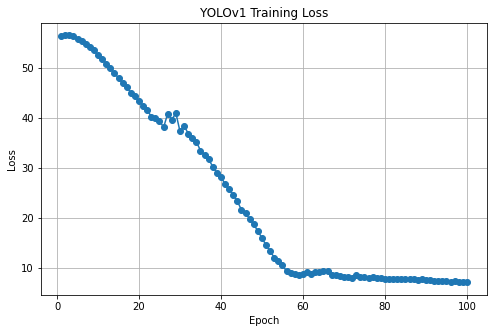

In [12]:
# -------------------------------
# 1️⃣ Hyperparameters
# -------------------------------
S, B, C = 7, 2, 20
num_epochs = 100
batch_size = 8
warmup_epochs = 15
warmup_start_lr = 1e-5
base_lr = 1e-3
max_grad_norm = 5

# -------------------------------
# 2️⃣ Dataset & Dataloader
# -------------------------------
#train_dataset = YoloDataset(X_train, y_train)
#test_dataset = YoloDataset(X_test, y_test)

#train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

total_iters_per_epoch = len(train_loader)
total_warmup_iters = warmup_epochs * total_iters_per_epoch

# -------------------------------
# 3️⃣ Model, Loss, Optimizer
# -------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = YOLOv1(S=S, B=B, C=C).to(device)
criterion = YoloLoss(S=S, B=B, C=C, l_obj=15, l_nobj=0.5)

optimizer = optim.SGD(model.parameters(), lr=base_lr, momentum=0.9, weight_decay=5e-4)

# Optional scheduler after warmup (MultiStepLR example)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

global_step = 0
train_losses = []

# -------------------------------
# 4️⃣ Training Loop
# -------------------------------
print(f"Starting training on {device} for {num_epochs} epochs...\n")

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for imgs, labels in progress_bar:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward
        preds = model(imgs)
        #loss = criterion.yolo_loss(preds, labels)
        loss = criterion.yolo_loss(preds, labels)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)

        # -------------------
        # Warmup LR
        # -------------------
        if global_step < total_warmup_iters:
            lr = warmup_start_lr + (base_lr - warmup_start_lr) * (global_step / total_warmup_iters)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr

        optimizer.step()
        global_step += 1

        running_loss += loss.item()
        progress_bar.set_postfix({"Loss": f"{loss.item():.4f}", "LR": f"{optimizer.param_groups[0]['lr']:.6f}"})

    # Scheduler step after each epoch (optional)
    #scheduler.step()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] | Avg Loss: {avg_loss:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f}")

# -------------------------------
# 5️⃣ Save model
# -------------------------------
torch.save(model.state_dict(), "yolov1_trained.pth")
print("\n💾 Model saved as yolov1_trained.pth")

# -------------------------------
# 6️⃣ Plot Training Loss
# -------------------------------
plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), train_losses, marker='o')
plt.title("YOLOv1 Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


✅ Training starts on cuda

first 10 outputs image 0: tensor([ 0.0150, -0.0133, -0.0095, -0.0145, -0.0063, -0.0076, -0.0129, -0.0018,
         0.0014,  0.0078], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([ 0.0164, -0.0146, -0.0090, -0.0154, -0.0051, -0.0100, -0.0089, -0.0013,
        -0.0021,  0.0126], device='cuda:0', grad_fn=<SliceBackward0>)
[001/500] Loss: 34.4660 | LR: 0.000010
first 10 outputs image 0: tensor([ 0.0156, -0.0124, -0.0091, -0.0147, -0.0075, -0.0094, -0.0123, -0.0027,
        -0.0009,  0.0107], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 outputs image 1: tensor([ 0.0184, -0.0120, -0.0082, -0.0134, -0.0050, -0.0068, -0.0120, -0.0012,
        -0.0002,  0.0071], device='cuda:0', grad_fn=<SliceBackward0>)
[002/500] Loss: 34.7690 | LR: 0.000076
first 10 outputs image 0: tensor([ 0.0143, -0.0128, -0.0069, -0.0158, -0.0076, -0.0118, -0.0153, -0.0036,
         0.0001,  0.0093], device='cuda:0', grad_fn=<SliceBackward0>)
first 10 output

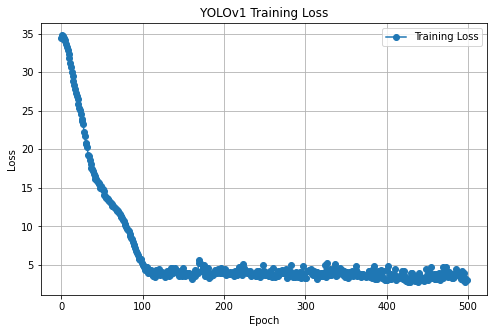

In [54]:
# -------------------------------
# Hyperparameters
# -------------------------------
S, B, C = 7, 2, 20
num_epochs = 500
batch_size = 8

warmup_epochs = 15
warmup_start_lr = 1e-5
base_lr = 1e-3

max_grad_norm = 5

# -------------------------------
# Model / Loss / Optimizer
# -------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = YOLOv1(S=S, B=B, C=C).to(device)
criterion = YoloLoss(S=S, B=B, C=C, l_obj=15, l_nobj=1)

optimizer = optim.SGD(model.parameters(), lr=warmup_start_lr, momentum=0.9, weight_decay=5e-4)

train_losses = []  # <--- pour le plot

print(f"✅ Training starts on {device}\n")

# -------------------------------
# Training Loop
# -------------------------------
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # --- Warmup LR ---
    if epoch < warmup_epochs:
        lr = warmup_start_lr + (base_lr - warmup_start_lr) * (epoch / warmup_epochs)
        for pg in optimizer.param_groups:
            pg['lr'] = lr
    else:
        for pg in optimizer.param_groups:
            pg['lr'] = base_lr

    # --- Iterations ---
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        preds = model(imgs)
        loss = criterion.yolo_loss(preds, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    print(f"[{epoch+1:03d}/{num_epochs}] Loss: {avg_loss:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f}")


# -------------------------------
# Save model
# -------------------------------
torch.save(model.state_dict(), "yolov1_trained.pth")
print("\n💾 Saved: yolov1_trained.pth")


# -------------------------------
# Plot training loss
# -------------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(train_losses, marker='o', label="Training Loss")
plt.title("YOLOv1 Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

train_dataset = YoloDataset(X_train, y_train)
test_dataset = YoloDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# -------------------------------
# 2️⃣ Initialize Model, Loss, Optimizer
# -------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
S, B, C = 7, 2, 20

model = YOLOv1(S=S, B=B, C=C).to(device)
criterion = YoloLoss(S=S, B=B, C=C)
#optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
optimizer = torch.optim.SGD(model.parameters(),lr=1e-2,momentum=0.9,weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[75, 105],gamma=0.1)


# -------------------------------
# 3️⃣ Training Loop with Progress Bar
# -------------------------------
num_epochs = 100
train_losses = []

print(f"Starting training on {device} for {num_epochs} epochs...\n")

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for imgs, labels in progress_bar:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        preds = model(imgs)
        loss = criterion.yolo_loss(preds, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        optimizer.step()

        running_loss += loss.item()
        progress_bar.set_postfix({"Loss": f"{loss.item():.4f}"})

    scheduler.step()
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] | Avg Loss: {avg_loss:.4f}")
    
torch.save(model.state_dict(), "yolov1_trained.pth")
print("\n💾 Model saved as yolov1_trained.pth")

# -------------------------------
# 4️⃣ Plot Training Loss Curve
# -------------------------------
plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), train_losses, marker='o')
plt.title("YOLOv1 Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [55]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
S, B, C = 7, 2, 20

model = YOLOv1(S=S, B=B, C=C).to(device)
criterion = YoloLoss(S=S, B=B, C=C)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

loaded_model = YOLOv1(S=S, B=B, C=C).to(device)
loaded_model.load_state_dict(torch.load("yolov1_trained.pth", map_location=device))
loaded_model.eval()
print("🔁 Loaded model from yolov1_trained.pth")


🔁 Loaded model from yolov1_trained.pth


In [56]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
S, B, C = 7, 2, 20

model = YOLOv1(S=S, B=B, C=C).to(device)
criterion = YoloLoss(S=S, B=B, C=C)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

loaded_model = YOLOv1(S=S, B=B, C=C).to(device)
loaded_model.load_state_dict(torch.load("yolov1_trained.pth", map_location=device))
loaded_model.eval()
print("🔁 Loaded model from yolov1_trained.pth")

# -------------------------------
# 7️⃣ Evaluate on Test Set
# -------------------------------
"""
test_loss = 0.0
with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Evaluating"):
        imgs, labels = imgs.to(device), labels.to(device)
        preds = loaded_model(imgs)
        loss = criterion.yolo_loss(preds, labels)
        test_loss += loss.item()

avg_test_loss = test_loss / len(test_loader)
print(f"\n📊 Test Loss: {avg_test_loss:.4f}")
"""

🔁 Loaded model from yolov1_trained.pth


'\ntest_loss = 0.0\nwith torch.no_grad():\n    for imgs, labels in tqdm(test_loader, desc="Evaluating"):\n        imgs, labels = imgs.to(device), labels.to(device)\n        preds = loaded_model(imgs)\n        loss = criterion.yolo_loss(preds, labels)\n        test_loss += loss.item()\n\navg_test_loss = test_loss / len(test_loader)\nprint(f"\n📊 Test Loss: {avg_test_loss:.4f}")\n'

In [57]:
print(train_dataset[0][1].shape)
train_dataset[0][1][3]

torch.Size([7, 7, 25])


tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.4813, 0.3530, 0.9893, 0.9340, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
       

In [58]:
img_path = X_train[0]
img = cv2.imread(img_path)
img = cv2.resize(img, (448, 448))
img_rgb = img[..., ::-1] / 255.0
img_tensor = torch.tensor(img_rgb, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)

with torch.no_grad():
    pred = model(img_tensor)[0]  # shape: [S, S, C+B*5]
    print(pred[2])

tensor([[-0.0064, -0.0035,  0.0088, -0.0087,  0.0085,  0.0022, -0.0083, -0.0074,
         -0.0081, -0.0073,  0.0131,  0.0036,  0.0105,  0.0025, -0.0091, -0.0078,
         -0.0075,  0.0150, -0.0024, -0.0033, -0.0026, -0.0028, -0.0064,  0.0151,
         -0.0100,  0.0102,  0.0098,  0.0002,  0.0116, -0.0002],
        [-0.0051, -0.0038, -0.0062, -0.0182, -0.0007,  0.0078, -0.0072, -0.0110,
         -0.0158, -0.0139,  0.0073, -0.0050,  0.0071, -0.0125, -0.0111, -0.0102,
          0.0026, -0.0133, -0.0133, -0.0016, -0.0004, -0.0048,  0.0086,  0.0005,
         -0.0066,  0.0149,  0.0122, -0.0020,  0.0138,  0.0094],
        [-0.0136,  0.0051, -0.0129, -0.0106, -0.0106, -0.0015,  0.0078,  0.0061,
         -0.0026, -0.0052, -0.0117,  0.0056, -0.0079, -0.0095, -0.0041,  0.0169,
         -0.0017,  0.0171,  0.0143, -0.0009, -0.0022,  0.0008,  0.0083,  0.0092,
          0.0064, -0.0043,  0.0153, -0.0121, -0.0060,  0.0070],
        [-0.0096, -0.0166, -0.0090,  0.0061, -0.0069,  0.0111, -0.0006,  0.0126

In [59]:
img_path = X_train[4]
classes = [i for i in range(20)]
print(img_path)
my_visual = YOLO_visual(S=S, B=B, C=C, classes=classes)
my_visual.Yolo_visualize_batch(loaded_model,X_train,device="cuda",score_threshold=0.026)

C:\Users\Lucas\Desktop\vacantion classes\Yolo project\data\Pascal_VOC\train\2012_003124_jpg.rf.37909e3d656ecae11aba5c836a0fb83e.jpg
Need exactly 2 images to compare.
first 10 outputs image 0: tensor([-3.1480, -0.1748, -0.1222, -0.1891, -0.2154,  0.2156, -0.1431,  0.0867,
         0.3149, -0.0306], device='cuda:0')
first 10 outputs image 1: tensor([-3.1480, -0.1748, -0.1222, -0.1891, -0.2154,  0.2156, -0.1431,  0.0867,
         0.3149, -0.0306], device='cuda:0')
Différence max entre prédictions image 0 et image 1 : 4.76837158203125e-07
[0.06278171 0.05914468 0.04582363 0.06149798 0.04279768 0.04761153
 0.04373336 0.05526226 0.05659089 0.04381394 0.04246892 0.04573846
 0.04590941 0.05295933 0.04793635 0.04428073 0.05904436 0.04255846
 0.04947041 0.05057597]
[0.04314734 0.05644041 0.04469853 0.0513579  0.04720215 0.04728153
 0.04176404 0.04942988 0.05256733 0.05727407 0.04808712 0.04971995
 0.04088209 0.04679606 0.05176562 0.05692742 0.05942075 0.05403119
 0.05006935 0.05113723]
[0.053033

In [60]:
img_path = X_train[0]
classes = [i for i in range(20)]
print(img_path)
my_visual = YOLO_visual(S=S, B=B, C=C, classes=classes)

my_visual.Yolo_visualize(loaded_model,img_path,device="cuda",score_threshold=0.01)

C:\Users\Lucas\Desktop\vacantion classes\Yolo project\data\Pascal_VOC\train\2008_006099_jpg.rf.ad2f70ca2d68b2e3396bf30a7a6cf83a.jpg
[0.06278171 0.05914467 0.04582362 0.06149798 0.04279767 0.04761153
 0.04373336 0.05526226 0.05659089 0.04381394 0.04246892 0.04573845
 0.0459094  0.05295933 0.04793634 0.04428073 0.05904435 0.04255845
 0.04947041 0.05057597]
[0.04314734 0.05644041 0.04469852 0.0513579  0.04720215 0.04728153
 0.04176404 0.04942988 0.05256732 0.05727407 0.04808712 0.04971995
 0.04088209 0.04679606 0.05176562 0.05692742 0.05942075 0.05403119
 0.05006935 0.05113723]
[0.05303364 0.04423121 0.04561052 0.05003888 0.05454642 0.06149334
 0.05930658 0.04462035 0.04725971 0.0476398  0.06306527 0.04966414
 0.04995554 0.04929523 0.05091081 0.05101014 0.04302263 0.05165712
 0.03779787 0.04584074]
[0.05594213 0.03653055 0.05931414 0.04036859 0.04445653 0.03835937
 0.06362137 0.04713712 0.05297755 0.04443152 0.04280315 0.04574831
 0.0536391  0.05145961 0.0584099  0.04654509 0.05749633 0.0

In [61]:
y_train[0][3][3]

tensor([1.0000, 0.4813, 0.3530, 0.9893, 0.9340, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000])

In [62]:
img_path = X_train[0]
img = cv2.imread(img_path)
img = cv2.resize(img, (448, 448))
img_rgb = img[..., ::-1] / 255.0
img_tensor = torch.tensor(img_rgb, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)

In [63]:
predict = model(img_tensor)
predict[:,3,3]

tensor([[ 1.5115e-02,  8.2013e-03, -1.7133e-02, -6.3852e-03, -6.2586e-03,
         -8.9169e-03,  1.3414e-02,  8.9537e-06,  4.1410e-03, -6.7453e-03,
          1.1676e-02, -8.0996e-03, -3.0443e-03,  5.8138e-03, -8.4178e-03,
          5.0426e-03, -4.5646e-03,  7.6815e-04, -6.2421e-03,  6.7920e-03,
         -6.1609e-03, -1.4043e-02,  4.2211e-03, -1.3700e-02, -1.5823e-02,
          8.8168e-03,  3.8852e-04,  1.6175e-02, -9.7629e-04, -9.8713e-03]],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [64]:
y_true = train_dataset[0][1]  # [S,S,C+5*B]
print(y_true.sum(dim=-1))  # voir si certaines cellules ont des objets
y_true[3]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 4.7577, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])


tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.4813, 0.3530, 0.9893, 0.9340, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
       